In [31]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from os import getcwd
from pathlib import Path
import sys
import seaborn as sns
from matplotlib import rcParams
import math
from importlib.metadata import version

Functions needed:

In [32]:
def roundup(x):
    ret = math.ceil(x/100)*100
    return(ret)

def violin_plots(filepath = None, print_means = False, print_mape = False, plot_name = None, 
                       b_threshold = True,ylim = None, ymin = None,
                      num_f1 = 1, filter_runs_by_alpha2 = False, plot_points = False, txt_header = False,
                t_method = "BD_1stO"):
    plt.style.use('default')    
    
    # ======
    if txt_header == False:
        df_temp = pd.read_csv(filepath, sep=" ", header=None)
        if num_f1 == 2:
            colnames = ["r1","r","u","t1","t_ssc","b","b1","M1","alpha1","M2","alpha2","gamma","gamma_old"];
            df_temp = df_temp.iloc[:,:len(colnames)];
            df_temp.columns = colnames;
        elif num_f1 == 1:
            colnames = ["r1","r","u","t1","t_ssc","b","b1","M1","alpha1","M2","alpha2","gamma"];
            df_temp = df_temp.iloc[:,:len(colnames)];
            df_temp.columns = colnames;
    else:
        df_temp = pd.read_csv(filepath, sep=" ", header=0)
        df_temp = df_temp.iloc[:,:12];
    
    all_runs = df_temp.shape[0];   
    df_temp = df_temp.dropna(axis = 0)
    df = df_temp;
    # ======
    if t_method == "BD_1stO":
        params_to_plot = ["r1","r","u","t1","t_BD_1stO"]
        name_list = ["r1","r","u","t1","t_BD_1stO","b","b1"];
        # make dataframe of the true values
        # to do this there needs to be a true_params.txt file in the directory
    else:
        print("t_method = {}".format(t_method))
        params_to_plot = ["r1","r","u","t1","t_ssc"]
        name_list = ["r1","r","u","t1","t_ssc","b","b1"];
        # make dataframe of the true values
        # to do this there needs to be a true_params.txt file in the directory
    
    finite_list = [];
    for i,row in df_temp.iterrows():
        if sum(row.values == float('inf'))>0:
            df = df.drop(labels = i,axis = 0);
        elif -1 in row.values:
            df = df.drop(labels = i,axis = 0);
            print("removed -1")
        elif filter_runs_by_alpha2:
            if row['alpha2'] < 0.1 or row['alpha2'] > 0.9:
                df = df.drop(labels = i,axis = 0);
            else:
                finite_list.append(i)
        else:
            finite_list.append(i)
    

    # get the main directory from the filepath of the data you're plotting
    for i,s in enumerate(filepath[::-1]):
        if s == "/":
            run_directory = filepath[:-i]
            break
    print("simulation directory is: %s" %(run_directory))

    true_param_filepath = join(run_directory,"true_params.txt")
    true_vals = pd.read_csv(true_param_filepath, sep=" ", header=None,nrows = 1)
    true_vals = true_vals.dropna(axis = 1);
    true_vals.columns = name_list;
    # compute percent errors
    pe_df = pd.DataFrame(np.zeros((len(finite_list),len(params_to_plot))));
    pe_df.columns = params_to_plot;
    
    df["t_BD_1stO"] = (1/df['r1'].values)*np.log(df['M1'].values*df['alpha1'].values) 
    
    counter = 0
    b_thresholded = 0;
    b1_thresholded = 0;
    b_color = ['k']*len(finite_list)
    b1_color = ['k']*len(finite_list)
    b_pre_thresholding = np.array([]);
    b1_pre_thresholding = np.array([]);
    for ind, i in enumerate(finite_list):
        if b_threshold == True:
            if df.loc[i,'b'] < df.loc[i,'r']:
                b_pre_thresholding = np.append(b_pre_thresholding, df.loc[i,'b'])
                df.loc[i,'b'] = df.loc[i,'r'];
                b_thresholded += 1;
                b_color[ind] = 'r';
            if df.loc[i,'b1'] < df.loc[i,'r1']:
                b1_pre_thresholding = np.append(b1_pre_thresholding, df.loc[i,'b1'])
                df.loc[i,'b1'] = df.loc[i,'r1'];
                b1_thresholded += 1;
                b1_color[ind] = 'r';
        for j in params_to_plot:
            pe_df.loc[ind,j] = 100*(df[j][i] - true_vals.loc[0][j])/true_vals.loc[0][j];
        counter += 1;
    b_pre_thresholding = 100*(b_pre_thresholding - true_vals.loc[0]['b'])/true_vals.loc[0]['b']
    b1_pre_thresholding = 100*(b1_pre_thresholding - true_vals.loc[0]['b1'])/true_vals.loc[0]['b1']
    
    print(counter)

    
    violin_dat = pe_df.values;
    fs = 30;
    locs = np.arange(len(params_to_plot))+1;
    median_props = dict(linewidth=4, color = 'black')
    
    fig_width = len(params_to_plot)*20/7;
        
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_width, 10))
    vp = ax.violinplot(violin_dat, positions = locs,
                  points=200, widths=0.7, showmeans=False,showextrema=False, showmedians=False)
    for bod in vp['bodies']:
        bod.set_facecolor('xkcd:azure')
        bod.set_alpha(.75)
    bp = ax.boxplot(violin_dat, positions=locs,widths=.3,whis=[2.5,97.5],showfliers=False,medianprops=median_props)
    if len(params_to_plot) == 5:
        ax.set_xticklabels(["$r_1$","$r$","$u$","$t_1$","$t$"],fontsize = 1.5*fs)
    elif len(params_to_plot) == 2:
        ax.set_xticklabels(["$b$","$b_1$"],fontsize = 1.5*fs)
    elif len(params_to_plot) == 7:
        ax.set_xticklabels(["$r_1$","$r$","$u$","$t_1$","$t$","$b$","$b_1$"],fontsize = 1.5*fs)
    ax.tick_params(axis = "y",labelsize = fs)
    if ylim == None:
        ylim_auto = roundup(max([item.get_ydata()[1] for item in bp['whiskers']]))
    else:
        ylim_auto = ylim

    ax.set_ylim(ymin, ylim_auto)
    mape_plotting_shift = (5/110)*(ylim_auto-ymin);
    mape_yloc = ylim_auto - mape_plotting_shift;
    mean_yloc = ylim_auto ;
    if print_means and not(print_mape):
        for j in locs:  
            avg = np.mean(violin_dat,axis = 0)[j-1];
            if len(str(float(str(abs(avg))[:4]))) == 3:
                ax.annotate(str(np.sign(avg)*float(str(abs(avg))[:4]))+'0'+'%',xy=(j-.15,mean_yloc),fontsize = fs,color = "black")
            else:
                ax.annotate(str(np.sign(avg)*float(str(abs(avg))[:4]))+'%',xy=(j-.15,mean_yloc),fontsize = fs,color = "black")
    elif print_mape and not(print_means):
        for j in locs:
            avg = np.mean(np.abs(violin_dat),axis = 0)[j-1];
            if len(str(float(str(abs(avg))[:4]))) == 3:
                ax.annotate(str(np.sign(avg)*float(str(abs(avg))[:4]))+'0'+'%',xy=(j-.15,mape_yloc),fontsize = fs,color = "black")
            else:
                ax.annotate(str(np.sign(avg)*float(str(abs(avg))[:4]))+'%',xy=(j-.15,mape_yloc),fontsize = fs,color = "black")
    elif print_means and print_mape:
        for j in locs:
            mape = np.mean(np.abs(violin_dat),axis = 0)[j-1];
            avg = np.mean(violin_dat,axis = 0)[j-1];
            ax.annotate(str(round(avg,2))+'%',xy=(j-.15,mean_yloc),fontsize = fs,color = "black")
            ax.annotate(str(round(mape,2))+'%',xy=(j-.15,mape_yloc),fontsize = fs,color = "slategrey")
            
    # if we want to plot all the data pointed, with jittered x value 
    if plot_points:
        for j in locs:
            xloc = np.random.uniform(j-.1,j+.1,size=len(finite_list))
            xloc_b = np.random.uniform(j-.1,j+.1,size=len(b_pre_thresholding))
            xloc_b1 = np.random.uniform(j-.1,j+.1,size=len(b1_pre_thresholding))
            if params_to_plot[j-1]== "b":
                plt.scatter(xloc,violin_dat[:,j-1], marker ='o', alpha = 0.3, color = b_color)
                plt.scatter(xloc_b, b_pre_thresholding, marker = 'x', alpha = 0.3, color = 'r')
            elif params_to_plot[j-1]== "b1":
                plt.scatter(xloc,violin_dat[:,j-1], marker ='o', alpha = 0.3, color = b1_color)
                plt.scatter(xloc_b1, b1_pre_thresholding, marker = 'x', alpha = 0.3, color = 'r')
            else:
                plt.scatter(xloc,violin_dat[:,j-1], marker ='o', alpha = 0.3, color = 'black')
    
    ax.yaxis.grid(True)
    plt.ylabel('% Error', fontsize = 1.5*fs)
    plt.tight_layout()
    if plot_name != None:
        plt.savefig(plot_name);

    plt.show()



# function to simulate sequencing reads from Monte Carlo simulation results
def gamma_simulation(run_directory = None, L = 2, r = None, pick_ind = 0,
                   using_truth = False, reps = 100, f1 = 0.01, f2 = 0.2, gamma_old = False,
                   row_indexed = False, typei = 1, param_set = None, save_data = True):
    # make sure inputs are of correct type
    if type(r) != int and type(r) != float:
        raise TypeError('r of type {} not float or int'.format(type(r)))
    if type(run_directory) != str:
        raise TypeError('run_directory of type {} not float or int'.format(type(run_directory)))
    if type(L) != int and type(L) != float:
        raise TypeError('L of type {} not float or int'.format(type(L)))
    run_directory = str(Path(getcwd()))+run_directory;
    
    onlyfiles = [f for f in listdir(run_directory) if isfile(join(run_directory, f))];
    SFS_files = [];
    type0_SFS = [];
    type1_SFS = [];
    for f in onlyfiles:
        if f[:6] == "run_i_":
            SFS_files.append(f);
    
    runs_temp = [];
    filepaths = [join(run_directory,f) for f in SFS_files];
    for filepath in filepaths:
        runs_temp.append( sum(1 for line in open(filepath)));
    if runs_temp[0] != runs_temp[1]:
        raise ValueError('different number of runs in type1 SFS ({}) than type0 SFS ({})!'.format(runs_temp[0] , runs_temp[1]))
    else:
        runs = runs_temp[0];
    
    for f in onlyfiles:
        if f[:2] == "r1":
            df_filepath = join(run_directory,f);
            df_temp = pd.read_csv(df_filepath, sep=" ", header=None)
            if gamma_old == True:
                df_temp.columns =["r1","r","u","t1","t","b","b1","M1","alpha1","M2","alpha2","gamma","gamma_old","nan"]
            else:
                df_temp.columns =["r1","r","u","t1","t","b","b1","M1","alpha1","M2","alpha2","gamma","nan"]
    
    if pick_ind == None:
        ind = [np.random.randint(100)];
        print("simulations being used: {}".format(ind))
    elif pick_ind == 'all':
        ind = range(runs)
        print("simulations being used: {}".format(ind))
    elif pick_ind == 'alpha2_criteria':
        ind = list(np.where(np.minimum(df_temp['M2'] > r,np.minimum(df_temp['alpha2'] > 0.1, df_temp['alpha2'] < 0.9)))[0])
        print("simulations being used: {}".format(ind))
        print("number simulations being used: {}".format(len(ind)))
    else:
        ind = [pick_ind];
        print("simulations being used: {}".format(ind))
    if row_indexed == True:
        for i,f in enumerate(SFS_files):
            if f[-5] == '0':
                for line in open(filepaths[i]):
                    if int(line.split(" ")[0]) == ind:
                        type0_SFS = np.array(line.strip().split(" ")[1:]);
            if f[-5] == '1':
                for line in open(filepaths[i]):
                    if int(line.split(" ")[0]) == ind:
                        type1_SFS = np.array(line.strip().split(" ")[1:]);
    else:
        for i,f in enumerate(SFS_files):
            #only considering type-1 population 
            if f[-5] == '0':
                line_counter = 0;
                for line in open(filepaths[i]):
                    if line_counter in ind:
                        type0_SFS.append(np.array(line.strip().split(" ")).astype(float));
                    line_counter += 1;
            if f[-5] == '1':
                line_counter = 0;
                for line in open(filepaths[i]):       
                    if line_counter in ind:
                        type1_SFS.append(np.array(line.strip().split(" ")).astype(float));
                    line_counter += 1;
    SFS = [];
    if typei == 'both':
        for i in range(len(ind)): 
            SFS.append(np.concatenate((type0_SFS[i], type1_SFS[i]), axis = None)/df_temp.loc[ind[i],"M2"])
    elif typei == 0:
        for i in range(len(ind)): 
            SFS.append(type0_SFS[i]/df_temp.loc[ind[i],"M2"])
    elif typei == 1:
        for i in range(len(ind)):  
            SFS.append(type1_SFS[i]/df_temp.loc[ind[i],"M2"])
    
    if using_truth == True:
        name_list = ["r1","r","u","t1","t","b","b1"];
        true_param_filepath = join(run_directory,"true_params.txt")
        true_vals = pd.read_csv(true_param_filepath, sep=" ", header=None,nrows = 1)
        true_vals = true_vals.dropna(axis = 1);
        true_vals.columns = name_list;

    if 2*L/r < f1:
        gamma_obs = np.zeros((len(ind),reps))
        PE_gamma_obs = np.zeros((len(ind),reps)) 
        true_gamma = np.zeros(len(ind));
        for i,sim in enumerate(SFS):
            gamma_temp = 0;

            # raise error if true mutation frequencies are greater than 1
            if np.any(sim > 1.):
                raise ValueError('mutation counts from saved SFS file > than M2')

            for j, true_freq in enumerate(sim):
                if true_freq >= f1 and true_freq <= f2:
                    gamma_temp += 1;


            if gamma_temp != df_temp.loc[ind[i],"gamma"]:
                raise ValueError('computed gamma ({}) != saved gamma ({})'.format(gamma_temp,df_temp.loc[ind[i],"gamma"]))
            for j in range(reps):
                Zi = np.zeros(len(sim));
                ri = np.zeros(len(sim));
                # ri allows for a possibly different coverage for each mutation, with average coverage of r
                ri = np.random.binomial(df_temp.loc[ind[i],"M2"],r/df_temp.loc[ind[i],"M2"],size=len(sim))
                # sample from binomial in (1) above to get number of reads covering mutation i
                Zi = np.random.binomial(ri,sim/2,size = len(sim));
                # record the mutant allele fraction 
                MAF = Zi/ri;
                # count the number of mutations between f1 and f2, and more reads than L to get observed gamma value, gamma_hat
                for k,MAFk in enumerate(MAF):
                    if Zi[k] > L and 2*MAFk >= f1 and 2*MAFk <= f2:
                        gamma_obs[i,j] += 1
                
                PE_gamma_obs[i,j] = 100*(gamma_obs[i,j] - df_temp.loc[ind[i],"gamma"])/df_temp.loc[ind[i],"gamma"]
                true_gamma[i] = df_temp.loc[ind[i],"gamma"];

        print("MPE gamma obs: {}".format(np.mean(PE_gamma_obs)))
        print("Average observed gamma: {}".format(np.mean(gamma_obs)))
        print("Average true gamma: {}".format(np.mean(true_gamma)))
        plt.close('all')

        fs = 30;
        fig, ax = plt.subplots(figsize = (15,10))
        ax.hist(PE_gamma_obs.flatten(),histtype = 'bar', alpha = 0.6, ec = 'k', bins = 50)
        for tick in ax.xaxis.get_major_ticks():  
            tick.label.set_fontsize(fs) 
        for tick in ax.yaxis.get_major_ticks():  
            tick.label.set_fontsize(fs)
        plt.show()

        if save_data == True:
            np.savetxt("PE_gamma_obs_"+str(param_set)+"_cvg_"+str(r)+"L_"+str(L)+".gz",PE_gamma_obs)
        return((PE_gamma_obs, true_gamma))
        
    else:
        adjusted_gamma = np.zeros((len(ind),reps))
        gamma_obs = np.zeros((len(ind),reps))
        PE_gamma = np.zeros((len(ind),reps))
        PE_gamma_obs = np.zeros((len(ind),reps)) 
        true_gamma = np.zeros(len(ind));



        for i,sim in enumerate(SFS):
            gamma_temp = 0;

            # raise error if true mutation frequencies are greater than 1
            if np.any(sim > 1.):
                raise ValueError('mutation counts from saved SFS file > than M2')

            for j, true_freq in enumerate(sim):
                if true_freq >= f1 and true_freq <= f2:
                    gamma_temp += 1;


            if gamma_temp != df_temp.loc[ind[i],"gamma"]:
                raise ValueError('computed gamma ({}) != saved gamma ({})'.format(gamma_temp,df_temp.loc[ind[i],"gamma"]))
            for j in range(reps):
                Zi = np.zeros(len(sim));
                ri = np.zeros(len(sim));
                # ri allows for a possibly different coverage for each mutation, with average coverage of r
                ri = np.random.binomial(df_temp.loc[ind[i],"M2"],r/df_temp.loc[ind[i],"M2"],size=len(sim))
                # sample from binomial in (1) above to get number of reads covering mutation i
                Zi = np.random.binomial(ri,sim/2,size = len(sim));
                # record the mutant allele fraction 
                MAF = Zi/ri;
                # count the number of mutations between f1 and f2, and more reads than L to get observed gamma value, gamma_hat
                for k,MAFk in enumerate(MAF):
                    if Zi[k] > L and 2*MAFk >= f1 and 2*MAFk <= f2:
                        gamma_obs[i,j] += 1
                adjusted_gamma[i,j] = gamma_obs[i,j]*((1/f1 - 1/f2)/(r/(2*(L)) - 1/f2))
                PE_gamma[i,j] = 100*(adjusted_gamma[i,j] - df_temp.loc[ind[i],"gamma"])/df_temp.loc[ind[i],"gamma"]
                PE_gamma_obs[i,j] = 100*(gamma_obs[i,j] - df_temp.loc[ind[i],"gamma"])/df_temp.loc[ind[i],"gamma"]
                true_gamma[i] = df_temp.loc[ind[i],"gamma"];

        print("MPE gamma adjusted: {}".format(np.mean(PE_gamma)))
        print("MAPE gamma adjusted: {}".format(np.mean(np.abs(PE_gamma))))
        print("MPE gamma obs: {}".format(np.mean(PE_gamma_obs)))
        print("MAPE gamma obs: {}".format(np.mean(np.abs(PE_gamma_obs))))
        print("Average adjusted gamma: {}".format(np.mean(adjusted_gamma)))
        print("Average observed gamma: {}".format(np.mean(gamma_obs)))
        print("Average true gamma: {}".format(np.mean(true_gamma)))
        plt.close('all')

        if False:
            fs = 30;
            fig, ax = plt.subplots(figsize = (15,10))
            ax.hist(PE_gamma.flatten(),histtype = 'bar', alpha = 0.6, ec = 'k', bins = 50)
            ax.hist(PE_gamma_obs.flatten(),histtype = 'bar', alpha = 0.6, ec = 'k', bins = 50)
            for tick in ax.xaxis.get_major_ticks():  
                tick.label.set_fontsize(fs) 
            for tick in ax.yaxis.get_major_ticks():  
                tick.label.set_fontsize(fs)
            plt.show()


        if save_data == True:
            np.savetxt("less_than_PE_gamma_"+str(param_set)+"_cvg_"+str(r)+"L_"+str(L)+".gz",PE_gamma)
            np.savetxt("less_than_PE_gamma_obs_"+str(param_set)+"_cvg_"+str(r)+"L_"+str(L)+".gz",PE_gamma_obs)
            np.savetxt("less_than_adjusted_gamma_"+str(param_set)+"_cvg_"+str(r)+"L_"+str(L)+".gz",adjusted_gamma)
        
        return((PE_gamma, PE_gamma_obs,adjusted_gamma, true_gamma))

# make the plot for comparing the gammma correction    
def make_plot(dat = None, title = '', plot_name = None, plot_type = 'density', xlims = None, belowf1 = False):
    fig, ax = plt.subplots(figsize = (15,10))
    if belowf1 == False:
        if plot_type == 'hist':
            ax.hist(dat.flatten(),histtype = 'bar', alpha = 0.6, ec = 'k', bins = 50)
            ax.set_ylabel('Count', fontsize = 20)
            ax.set_xlabel('Percent error', fontsize = 20)
            ax.set_title(title, fontsize = 30)
            fig.savefig(plotname, dpi = 300)
            plt.show()
        elif plot_type == 'density':
            legend_labels = ["$\gamma$", "$\gamma_{obs}$"]
            fs = 30;
            for i,d in enumerate(dat):
                sns.distplot(d, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3,'label':legend_labels[i]})
            plt.legend(fontsize = fs)
            plt.xlabel("Percent error, relative to true $\gamma$", fontsize = 1.5*fs)
            plt.ylabel("density", fontsize = 1.5*fs)

            if type(xlims) == list:
                plt.xlim(xlims[0],xlims[1])
            ylim_max = ax.get_ylim()[1];
            plt.ylim(0,ylim_max)
            plt.vlines(x = 0, ymin = 0, ymax = ylim_max, linestyle = 'dashed')
            for tick in ax.xaxis.get_major_ticks():  
                tick.label.set_fontsize(fs) 
            for tick in ax.yaxis.get_major_ticks():  
                tick.label.set_fontsize(fs)
            if plot_name != None:
                plt.savefig(plot_name,dpi = 500);
            plt.show()
    else:
        if plot_type == 'hist':
            ax.hist(dat.flatten(),histtype = 'bar', alpha = 0.6, ec = 'k', bins = 50)
            ax.set_ylabel('Count', fontsize = 20)
            ax.set_xlabel('Percent error', fontsize = 20)
            ax.set_title(title, fontsize = 30)
            fig.savefig(plotname, dpi = 300)
            plt.show()
        elif plot_type == 'density':
            fs = 30;
            plt.rcParams['font.family'] = 'sans-serif'
            plt.rcParams['font.sans-serif'] = ['Helvetica'] 
            sns.distplot(dat, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3,'label':"$\gamma_{obs}$"}, color = sns.color_palette()[1])
            plt.legend(fontsize = fs)
            plt.xlabel("Percent error, relative to true $\gamma$", fontsize = 1.5*fs)
            plt.ylabel("density", fontsize = 1.5*fs)

            if type(xlims) == list:
                plt.xlim(xlims[0],xlims[1])
            ylim_max = ax.get_ylim()[1];
            plt.ylim(0,ylim_max)
            plt.vlines(x = 0, ymin = 0, ymax = ylim_max, linestyle = 'dashed')
            for tick in ax.xaxis.get_major_ticks():  
                tick.label.set_fontsize(fs) 
            for tick in ax.yaxis.get_major_ticks():  
                tick.label.set_fontsize(fs)
            if plot_name != None:
                plt.savefig(plot_name,dpi = 800);
            plt.show()

def t1_correction_error(filepath = None, print_means = False, print_mape = False, plot_name = None, 
                       b_threshold = True,ylim = None, ymin = None, xlims = None,
                      num_f1 = 1, filter_runs_by_alpha2 = False, plot_points = False, params_to_plot = ["t1","t1_uncorrected"]):
    plt.style.use('default')
    df_temp = pd.read_csv(filepath, sep=" ", header=None)
        
    all_runs = df_temp.shape[0];
    if num_f1 == 2:
        df_temp.columns =["r1","r","u","t1","t","b","b1","M1","alpha1","M2","alpha2","gamma","gamma_old","nan"]
    elif num_f1 == 1:
        df_temp.columns =["r1","r","u","t1","t","b","b1","M1","alpha1","M2","alpha2","gamma","nan"]
    df_temp = df_temp.drop(axis = 1, labels = "nan")
    df_temp = df_temp.dropna(axis = 0)
    df = df_temp;
    
    finite_list = [];
    for i,row in df_temp.iterrows():
        if sum(row.values == float('inf'))>0:
            df = df.drop(labels = i,axis = 0);
        elif -1 in row.values:
            df = df.drop(labels = i,axis = 0);
            print("removed -1")
        elif filter_runs_by_alpha2:
            if row['alpha2'] < 0.1 or row['alpha2'] > 0.9:
                df = df.drop(labels = i,axis = 0);
            else:
                finite_list.append(i)
        else:
            finite_list.append(i)
    

    name_list = ["r1","r","u","t1","t","b","b1"];
    # make dataframe of the true values
    # to do this there needs to be a true_params.txt file in the directory
    
    # get the main directory from the filepath of the data you're plotting
    for i,s in enumerate(filepath[::-1]):
        if s == "/":
            run_directory = filepath[:-i]
            break
    print("simulation directory is: %s" %(run_directory))

    true_param_filepath = join(run_directory,"true_params.txt")
    true_vals = pd.read_csv(true_param_filepath, sep=" ", header=None,nrows = 1)
    true_vals = true_vals.dropna(axis = 1);
    true_vals.columns = name_list;
    # compute percent errors
    pe_df = pd.DataFrame(np.zeros((len(finite_list),2)));
    pe_df.columns = ["t1","t1_uncorrected"];
    
    print("dimension of data to plot:")
    print(pe_df.values.shape)
    
    counter = 0
    df['t1_uncorrected'] = df['t1'].values + 1/df['r1'].values;

        
    for ind, i in enumerate(finite_list):
        for j in params_to_plot:
            pe_df.loc[ind,j] = 100*(df.loc[i,j] - true_vals.loc[0]['t1'])/true_vals.loc[0]['t1'];
            if pe_df.loc[ind,j] > 150:
                print("run {} had PE = {} > 150%".format(i,pe_df.loc[ind,j]))
        counter += 1;

    print("t1 PE: {} (pm {}) ".format(np.mean(pe_df['t1']),np.std(pe_df['t1'])))                 
    print("t1 uncorrected PE: {} (pm {}) ".format(np.mean(pe_df['t1_uncorrected']),np.std(pe_df['t1_uncorrected'])))
    print("t1 MAPE: {} (pm {}) ".format(np.mean(np.abs(pe_df['t1'])),np.std(np.abs(pe_df['t1']))))               
    print("t1 uncorrected MAPE: {} (pm {}) ".format(np.mean(np.abs(pe_df['t1_uncorrected'])),np.std(np.abs(pe_df['t1_uncorrected']))))
    legend_labels = ["$t_1$, with correction", "$t_1$, no correction"]
    fs = 30;
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Helvetica']    
    fig, ax = plt.subplots(figsize = (15,10))
    for i,name in enumerate(params_to_plot):
        sns.distplot(pe_df[name], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3,'label':legend_labels[i]})
    plt.legend(fontsize = fs)
    plt.xlabel("Percent error of estimate", fontsize = 1.5*fs)
    plt.ylabel("density", fontsize = 1.5*fs)
    
    if type(xlims) == list:
        plt.xlim(xlims[0],xlims[1])
    ylim_max = ax.get_ylim()[1];
    plt.ylim(0,ylim_max)
    plt.vlines(x = 0, ymin = 0, ymax = ylim_max, linestyle = 'dashed')
    #plt.ylim(0,0.025)
    for tick in ax.xaxis.get_major_ticks():  
        tick.label.set_fontsize(fs) 
    for tick in ax.yaxis.get_major_ticks():  
        tick.label.set_fontsize(fs)
    plt.tight_layout();
    if plot_name != None:
        plt.savefig(plot_name, dpi = 800);
    
    return(1.0)
            

## Calculate parameters from saved outputs of Monte Carlo simulations

# fast growing, $u = 1$

simulation directory is: data/fast_growing_g1_u1_paper/
135


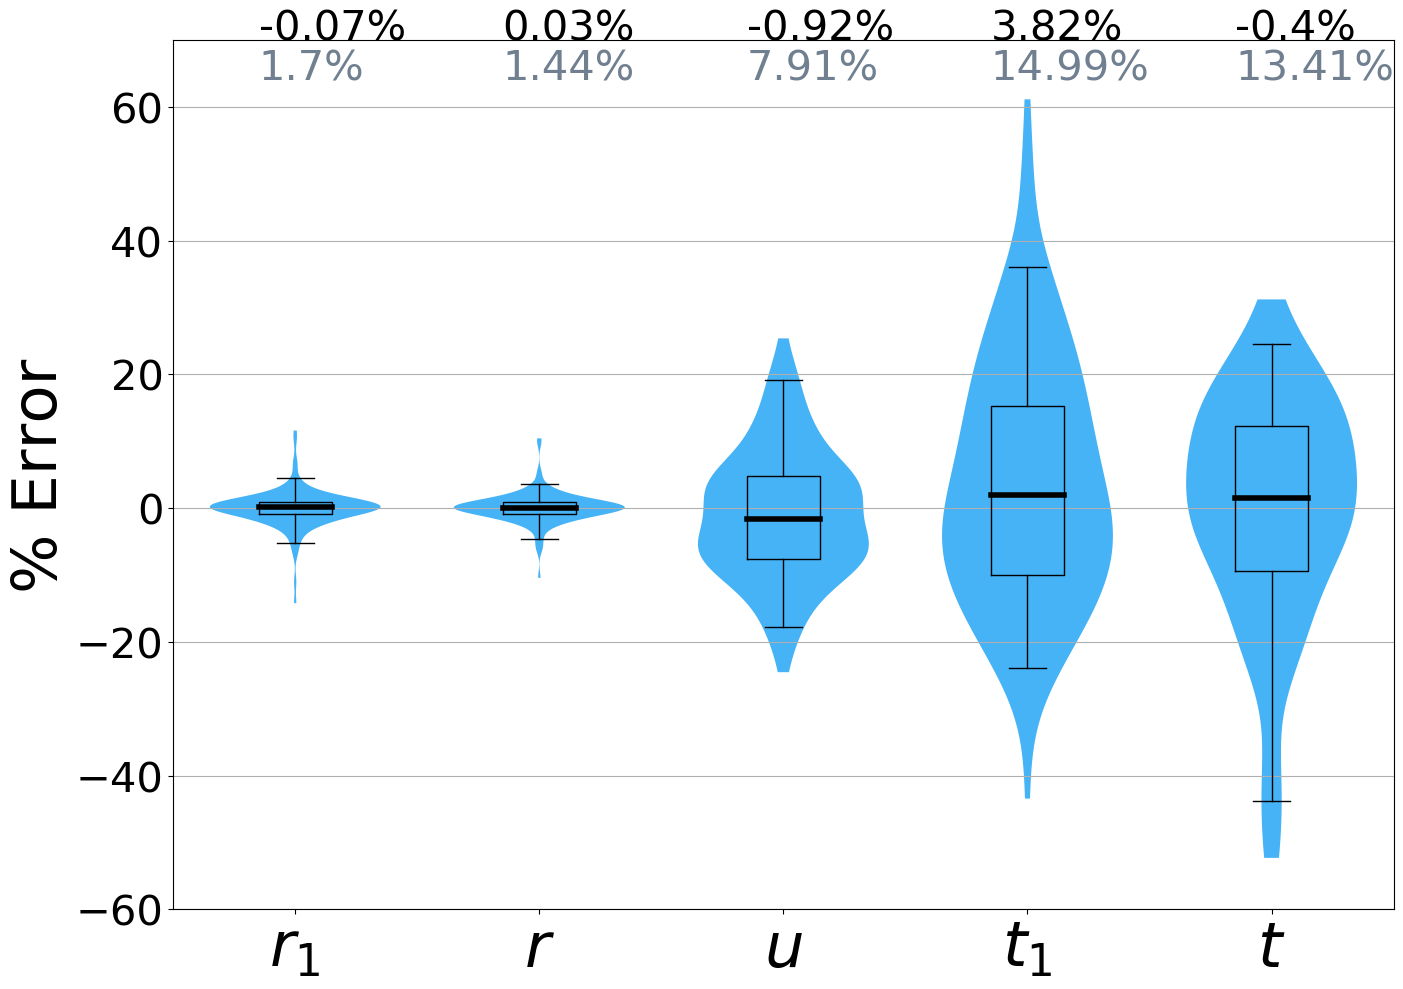

In [19]:
# change plot_name to filename if you want to save
plotname_in = "fastgrowing_g_1_u_1.svg"
violin_plots(filepath = "data/fast_growing_g1_u1_paper/r1_r_u_t1_t_b_b1_M1_alpha1_M2_alpha2_gamma_0020cells_f1_p01_f2_p2.txt",
             print_means = True, print_mape = True, plot_name = plotname_in, ylim = 70, ymin = -60, 
             num_f1 = 1,plot_points = False,filter_runs_by_alpha2 = False)

# fast growing, $ u = 3$

simulation directory is: data/fast_growing_g1_u3_paper/
130


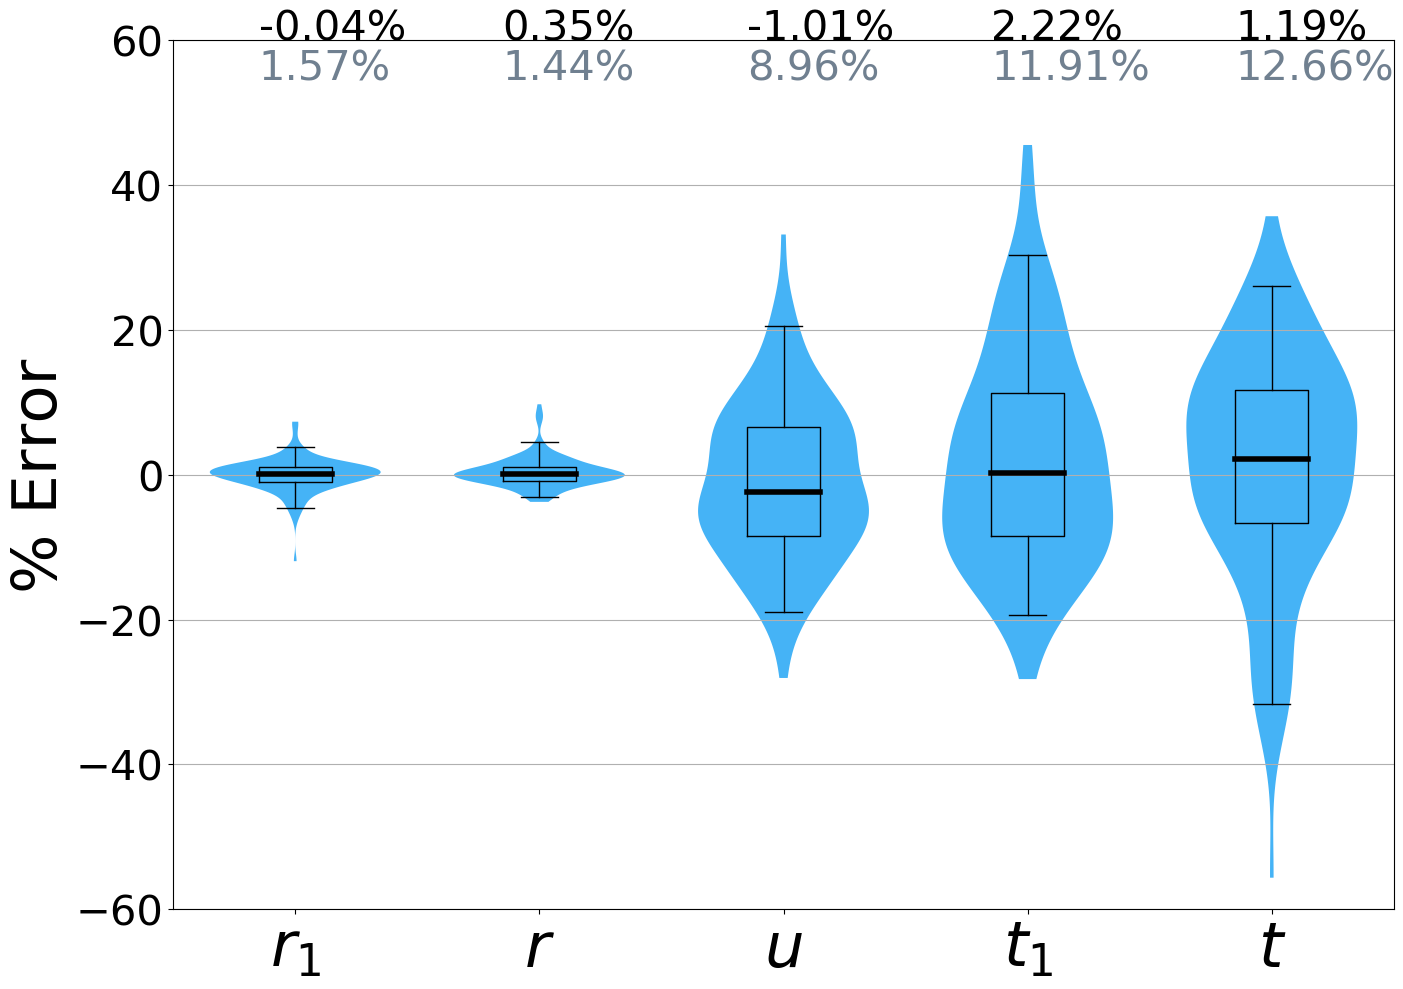

In [20]:
plotname_in = "fastgrowing_g_1_u_3.svg"
violin_plots(filepath = "data/fast_growing_g1_u3_paper/r1_r_u_t1_t_b_b1_M1_alpha1_M2_alpha2_gamma_0020cells_f1_p01_f2_p2.txt",
                print_means = True, print_mape = True, plot_name = plotname_in, ylim = 60, ymin = -60, 
             num_f1 = 1,plot_points = False,filter_runs_by_alpha2 = False)

## No death, u = 1

simulation directory is: data/d_0_u1_paper/
290


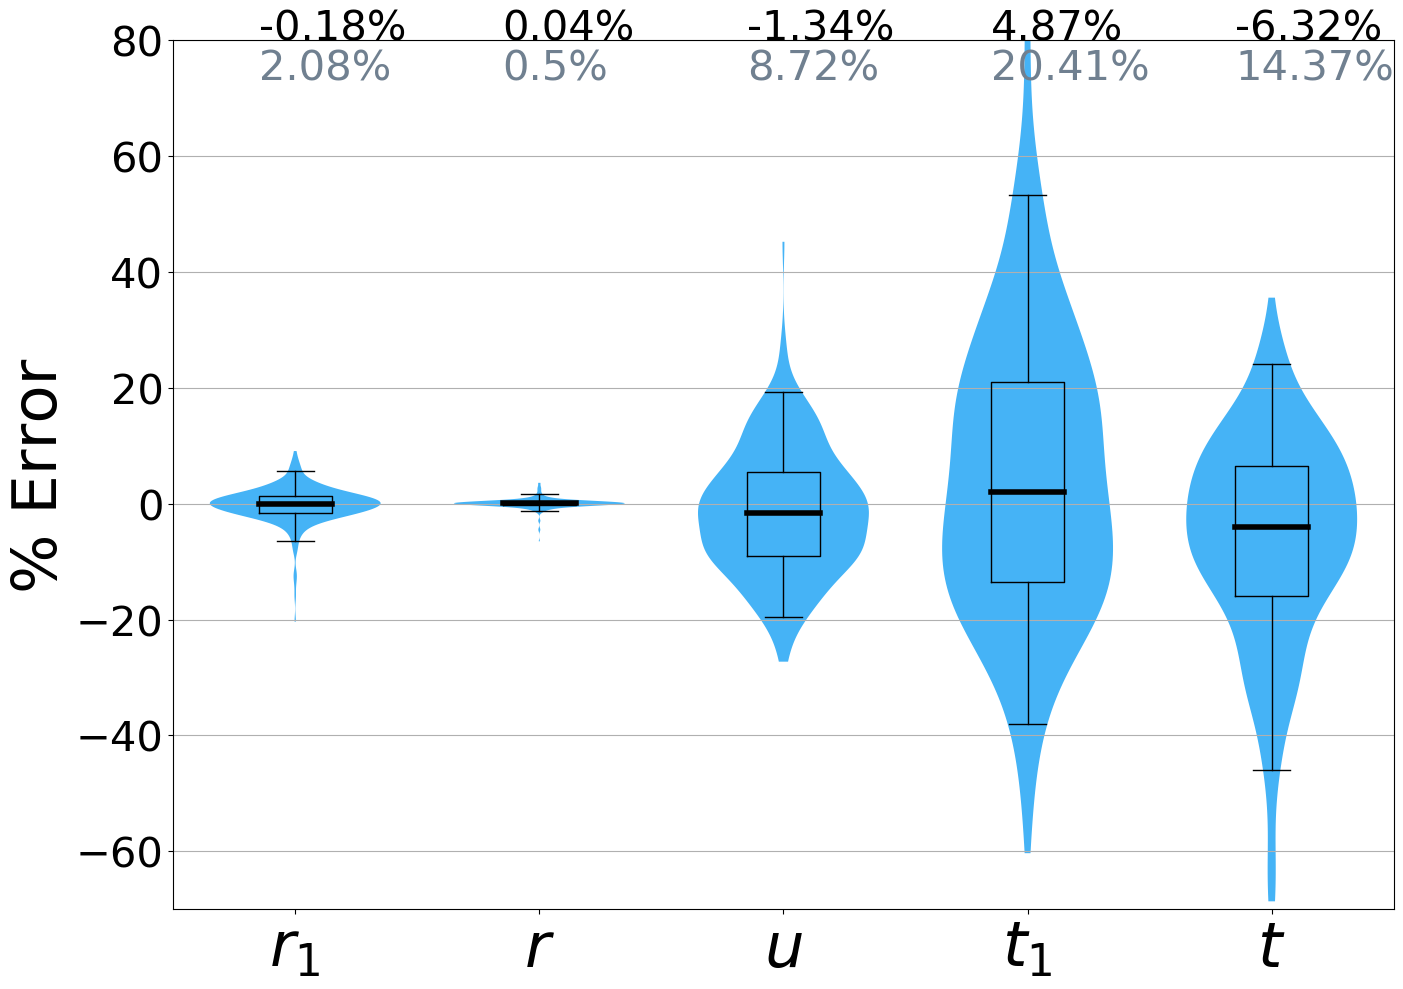

In [21]:
plotname_in = "nodeath_u_1.svg"
violin_plots(filepath = "data/d_0_u1_paper/r1_r_u_t1_t_b_b1_M1_alpha1_M2_alpha2_gamma_0020cells_f1_p01_f2_p2.txt",
    print_means = True, print_mape = True, plot_name = plotname_in, ylim = 80, ymin = -70, 
             num_f1 = 1,plot_points = False,filter_runs_by_alpha2 = False)

## No death, u = 10

simulation directory is: data/d_0_u_10_paper/
301


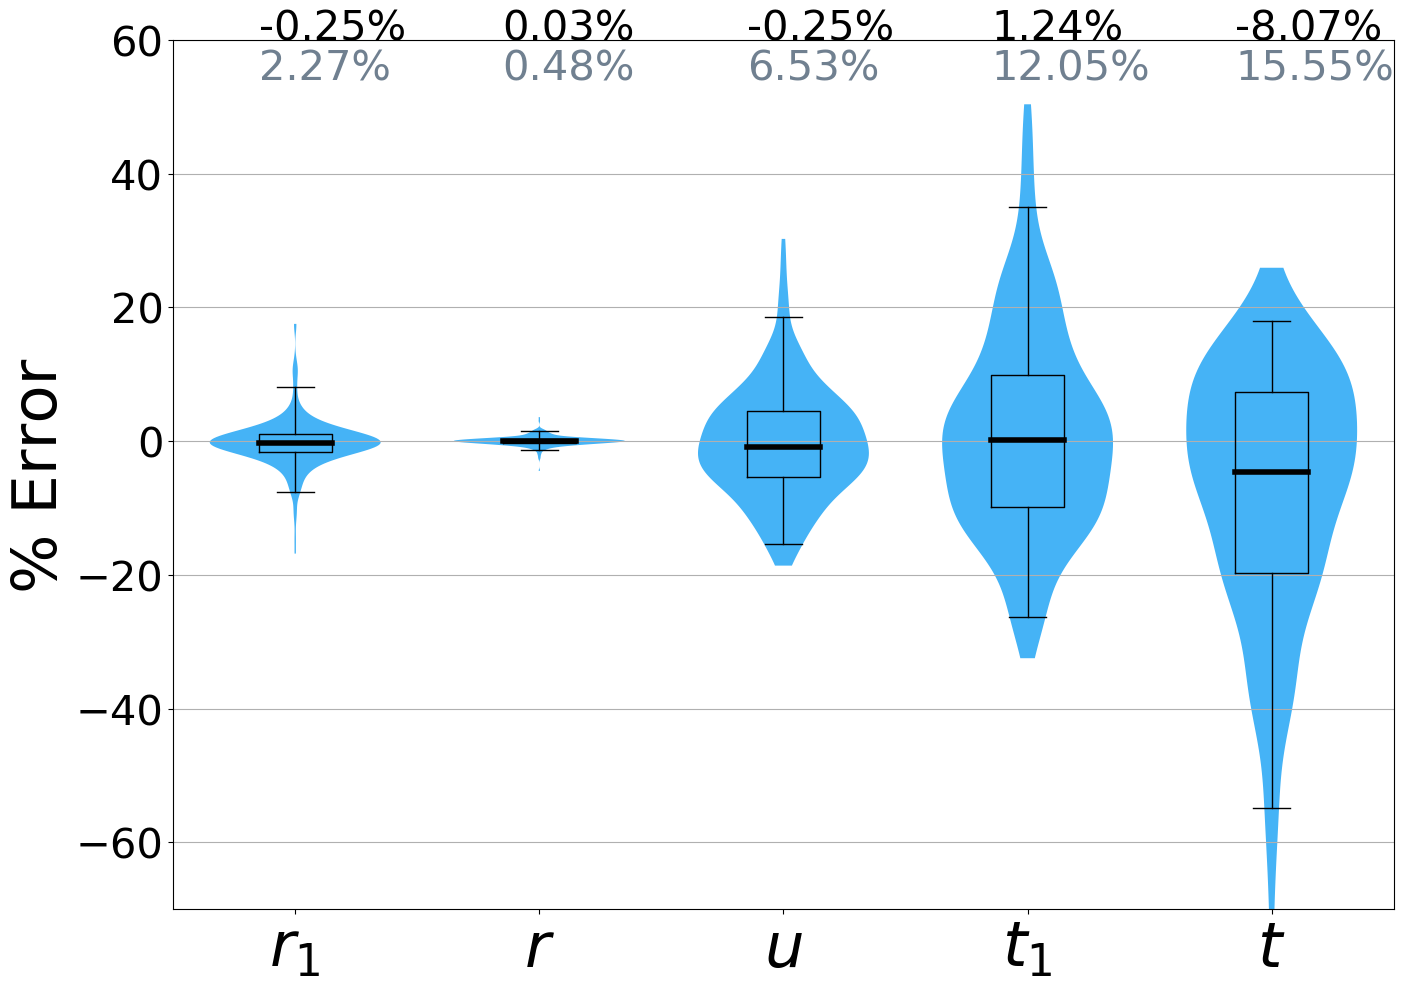

In [22]:
plotname_in = "nodeath_u_10.svg"
violin_plots(filepath = "data/d_0_u_10_paper/r1_r_u_t1_t_b_b1_M1_alpha1_M2_alpha2_gamma_0020cells_f1_p01_f2_p2.txt",
            print_means = True, print_mape = True, plot_name = plotname_in, ylim = 60, ymin = -70, 
             num_f1 = 1,plot_points = False,filter_runs_by_alpha2 = False)

## Slow growing, u = 1

simulation directory is: data/slow_u_1_paper/
225


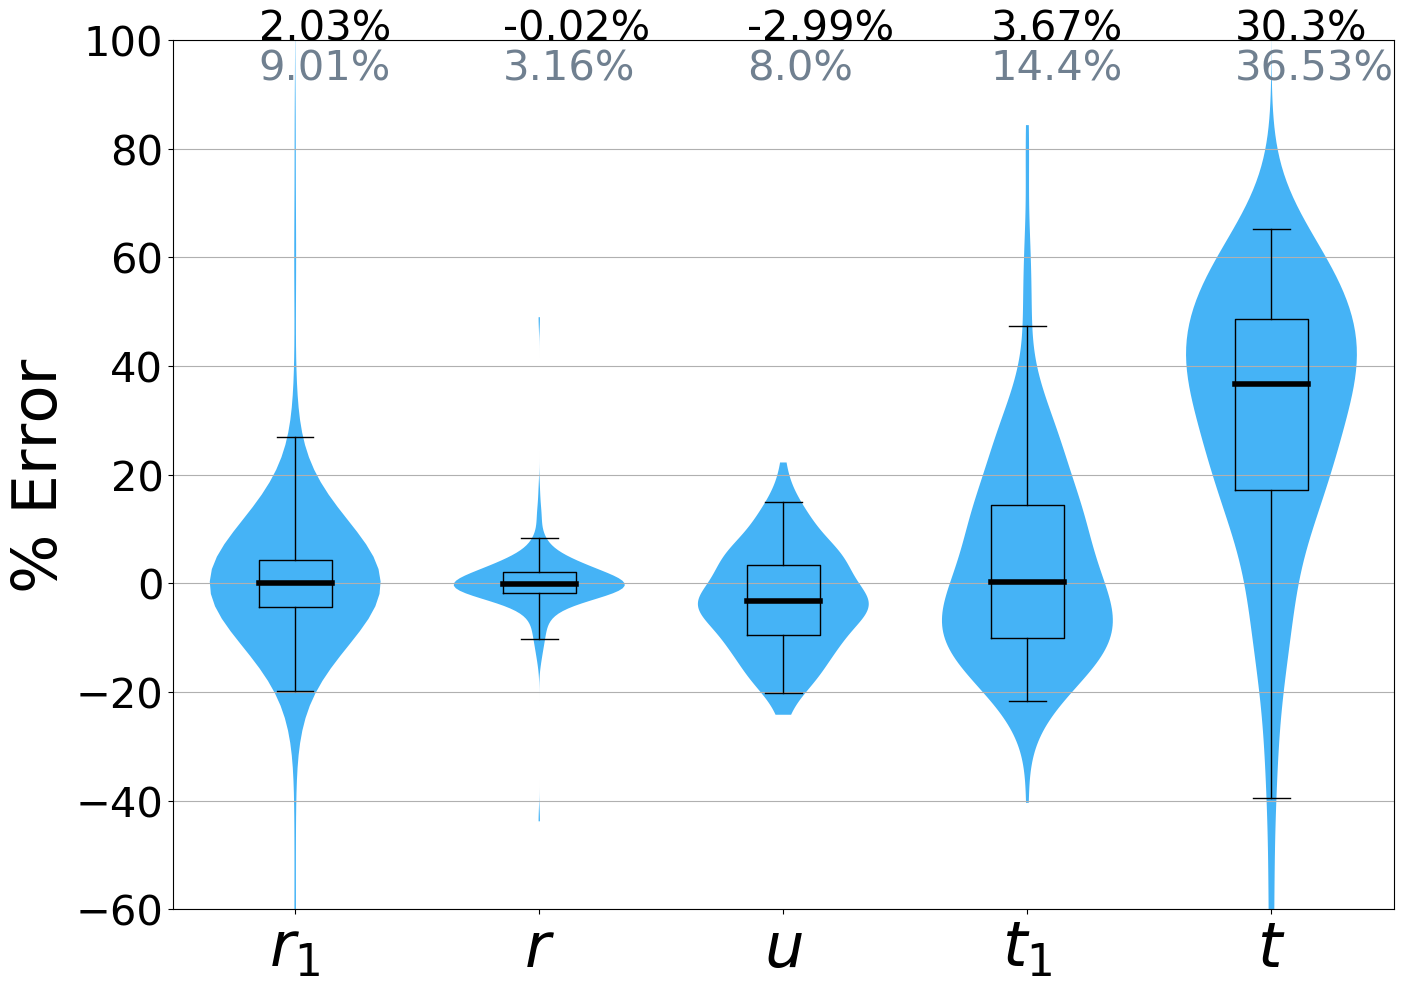

In [23]:
plotname_in = "slow_u_1.svg"
violin_plots(filepath = "data/slow_u_1_paper/r1_r_u_t1_t_b_b1_M1_alpha1_M2_alpha2_gamma_0020cells_f1_p01_f2_p2.txt",             
    print_means = True, print_mape = True, plot_name = plotname_in, ylim = 100, ymin = -60, 
             num_f1 = 1,plot_points = False,filter_runs_by_alpha2 = False)

## Slow growing, u = 5

simulation directory is: data/slow_u_5_paper/
249


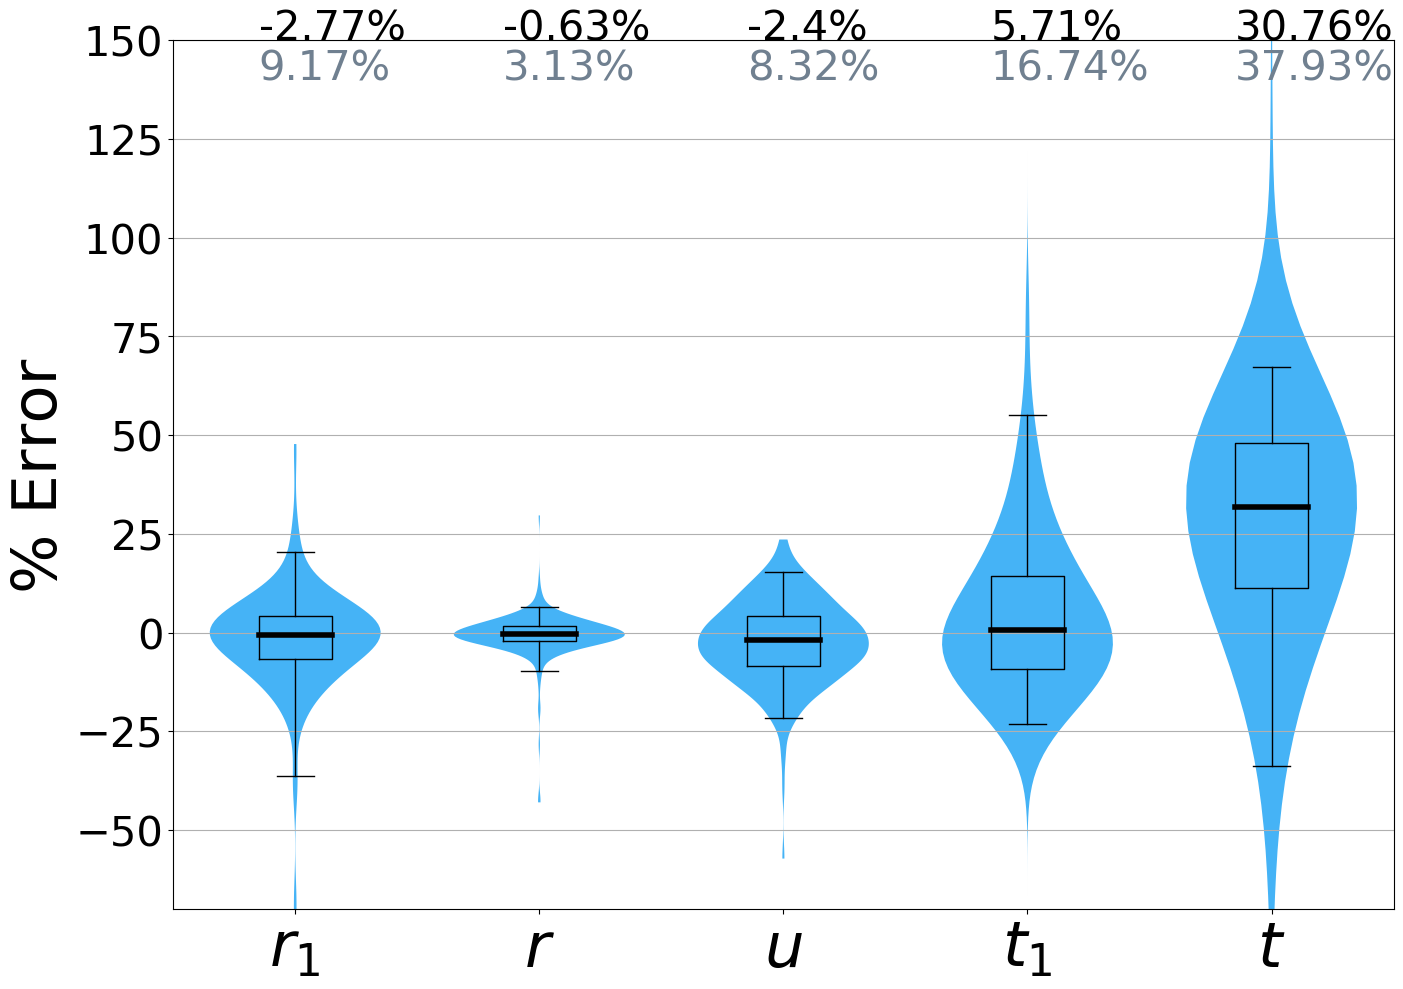

In [24]:
plotname_in = "slow_u_5.svg"
violin_plots(filepath = "data/slow_u_5_paper/r1_r_u_t1_t_b_b1_M1_alpha1_M2_alpha2_gamma_0020cells_f1_p01_f2_p2.txt",
            print_means = True, print_mape = True, plot_name = plotname_in, ylim = 150, ymin = -70, 
             num_f1 = 1,plot_points = False,filter_runs_by_alpha2 = False)

## Calculate the accuracy of $t_1$ with and without the correction for mutations that reached fixation in type-1 population, but occurred after $t_1$

For simulated fast growing tumor with $u = 1$, plot the accuracy or $t_1$ with and without correction:

simulation directory is: data/fast_growing_g1_u1_paper/
dimension of data to plot:
(135, 2)
t1 PE: 3.8217428571428584 (pm 18.50063771808291) 
t1 uncorrected PE: 14.041864011857369 (pm 18.529379617217206) 
t1 MAPE: 14.989986243386243 (pm 11.496939891334813) 
t1 uncorrected MAPE: 17.95329232928416 (pm 14.771294745746088) 


1.0

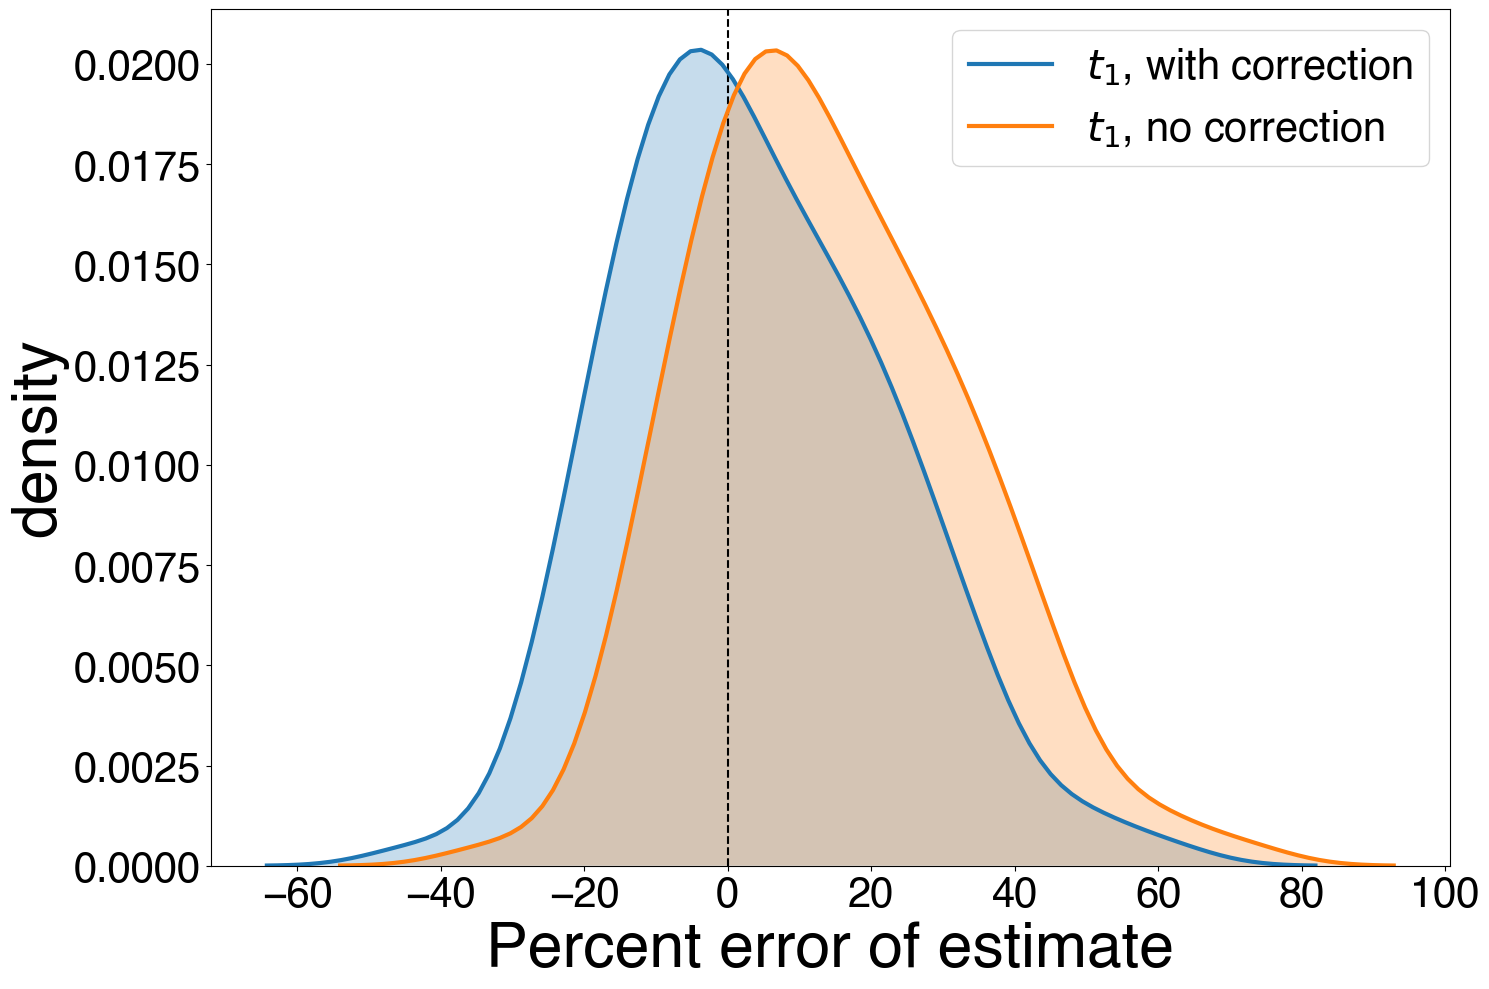

In [38]:
plotname_in = "t1_fast_u_1.svg"
t1_correction_error(filepath = "data/fast_growing_g1_u1_paper/r1_r_u_t1_t_b_b1_M1_alpha1_M2_alpha2_gamma_0020cells_f1_p01_f2_p2.txt",
                     print_means = True, print_mape = True, plot_name = plotname_in, num_f1 = 1,filter_runs_by_alpha2 = False)

For simulated slow growing tumor with $u = 5$, plot the accuracy or $t_1$ with and without correction:

simulation directory is: data/slow_u_5_paper/
dimension of data to plot:
(249, 2)
run 157 had PE = 256.51666666666665 > 150%
run 157 had PE = 207.57637089109514 > 150%
run 161 had PE = 195.67666666666673 > 150%
run 161 had PE = 215.15890665669176 > 150%
t1 PE: 5.707031682284694 (pm 29.2906020316332) 
t1 uncorrected PE: 21.982092307001942 (pm 27.457451343831472) 
t1 MAPE: 16.744257920571176 (pm 24.701000074642838) 
t1 uncorrected MAPE: 23.282006864721538 (pm 26.364221453391828) 


1.0

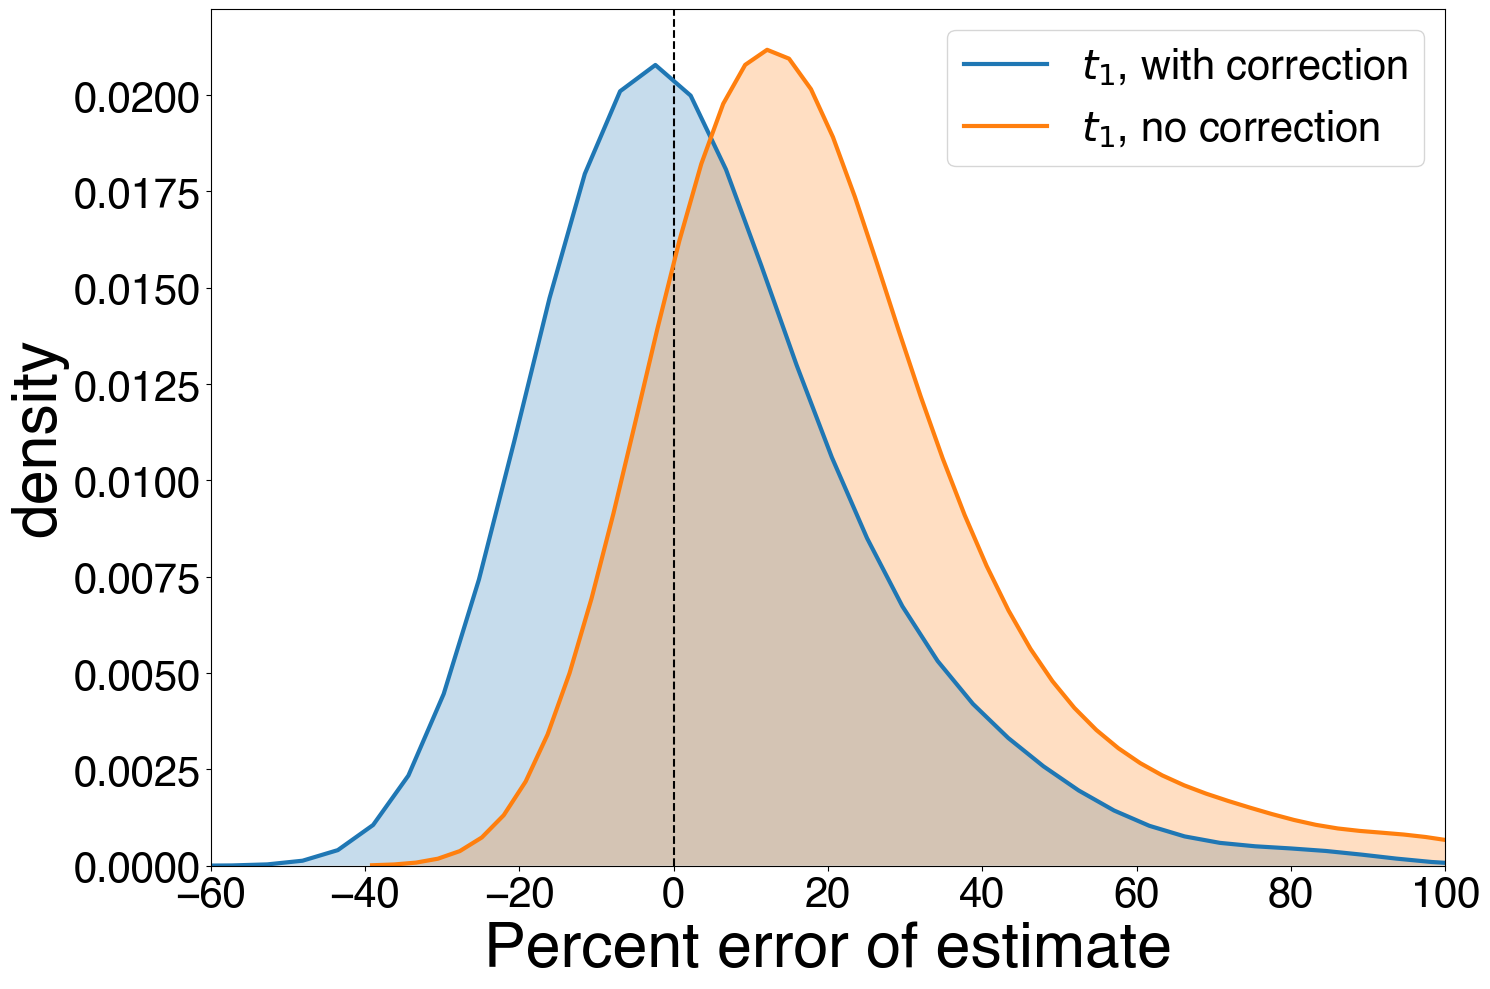

In [33]:
plotname_in = "t1_slow_u_5.svg"
t1_correction_error(filepath = "data/slow_u_5_paper/r1_r_u_t1_t_b_b1_M1_alpha1_M2_alpha2_gamma_0020cells_f1_p01_f2_p2.txt",
                     print_means = True, print_mape = True, plot_name = plotname_in, num_f1 = 1,
                    filter_runs_by_alpha2 = False, xlims = [-60,100])

## Simulate sequencing reads from Monte Carlo simulations of fast growing tumor

fast growing, $u = 1$, 100x coverage. Run the next cell to simulate sequencing reads. Or instead, you can use the saved outputs of our simulations contained in `data` directory and skip the next cell.

In [22]:
# run this cell to run the simulation (can use our simulated values in the text file alternatively)
# in which case you can skip this cell
fast_g1_u1 = gamma_simulation(run_directory = "/data/fast_growing_g1_u1_paper", 
                    L = 2, r = 100, pick_ind = 'all', using_truth = False, reps = 100, 
                               f1 = 0.01, f2 = 0.2, typei = 'both', param_set="fast_growing_g1_u1", save_data=False)



simulations being used: range(0, 135)
MPE gamma adjusted: -3.44821299507452
MAPE gamma adjusted: 10.306353848835178
MPE gamma obs: -79.67330799896307
MAPE gamma obs: 79.67330799896307
Average adjusted gamma: 1073.0717962962963
Average observed gamma: 225.90985185185184
Average true gamma: 1109.125925925926


In [36]:
# load the data from simulations
fast_g1_u1_100 = [None,None];
fast_g1_u1_100[0] = np.loadtxt("data/less_than_PE_gamma_fast_growing_g1_u1_cvg_100L_2")
print(np.mean(fast_g1_u1_100[0]))
print(fast_g1_u1_100[0].shape)
fast_g1_u1_100[1] = np.loadtxt("data/less_than_PE_gamma_obs_fast_growing_g1_u1_cvg_100L_2.gz")
print(np.mean(fast_g1_u1_100[1]))
print(fast_g1_u1_100[1].shape)

-3.3619684338418074
(135, 100)
-79.65515124922986
(135, 100)


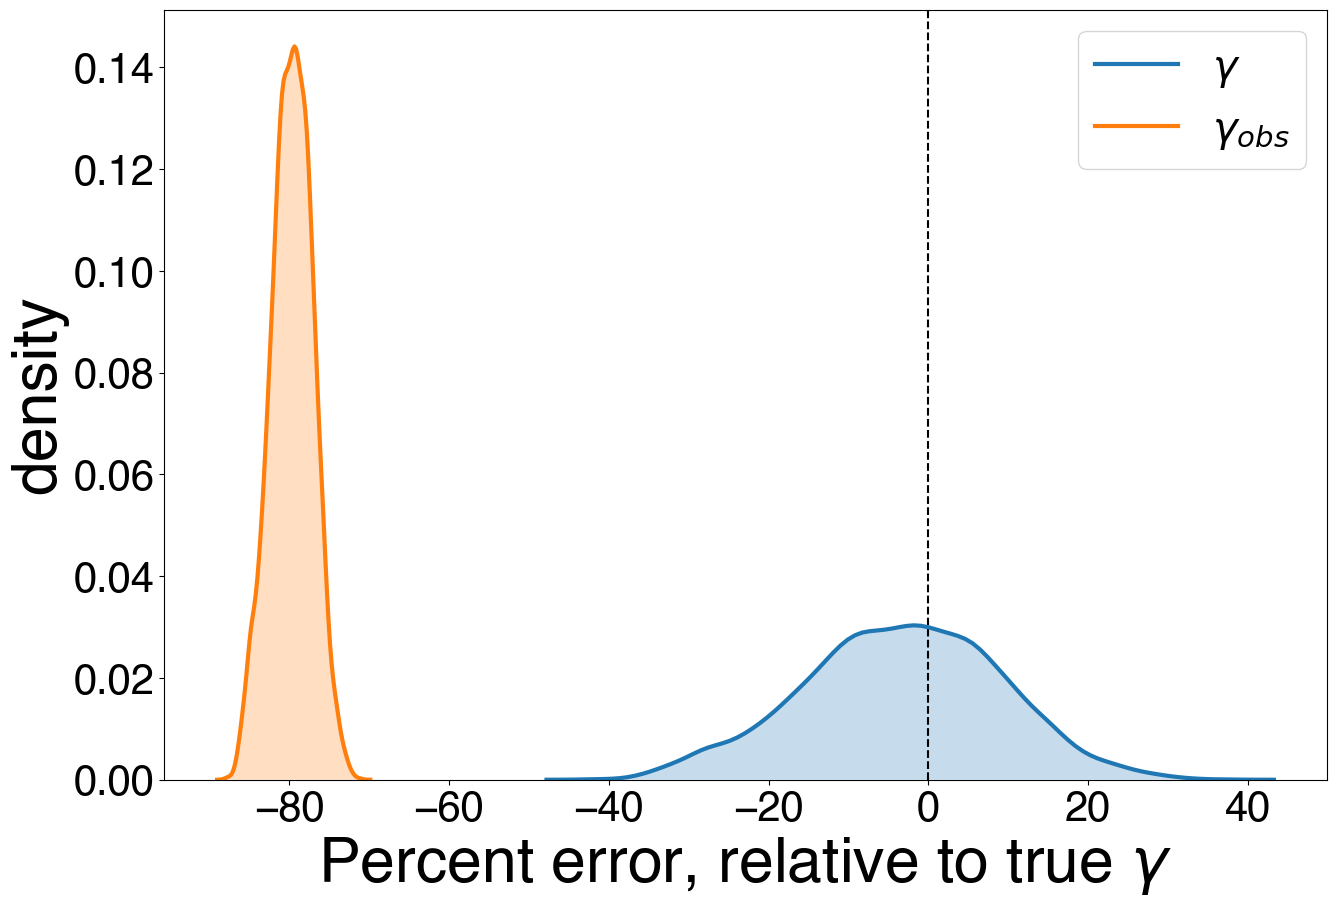

In [37]:
# plot the simulation results
plotname_in = "L2_fast_g1_u1_cvg_100_gamma_PEs.svg";
make_plot((fast_g1_u1_100[0],fast_g1_u1_100[1]), plot_name = plotname_in, plot_type = 'density')

fast growing, u = 1, 200x coverage. Run the next cell to simulate sequencing reads. Or instead, you can use the saved outputs of our simulations contained in `data` directory and skip the next cell.

In [23]:
# run this cell to run the simulation (can use our simulated values in the text file alternatively)
# in which case you can skip this cell
fast_g1_u1 = gamma_simulation(run_directory = "/data/fast_growing_g1_u1_paper", 
                    L = 2, r = 200, pick_ind = 'all', using_truth = False, reps = 100, 
                               f1 = 0.01, f2 = 0.2, typei = 'both', param_set="fast_growing_g1_u1",save_data=False)



simulations being used: range(0, 135)
MPE gamma adjusted: -1.433149090165247
MAPE gamma adjusted: 5.862811588490588
MPE gamma obs: -53.31043904270985
MAPE gamma obs: 53.31043904270985
Average adjusted gamma: 1092.6951604938272
Average observed gamma: 517.5924444444445
Average true gamma: 1109.125925925926


In [34]:
# load the data from simulations
fast_g1_u1_200 = [None,None];
fast_g1_u1_200[0] = np.loadtxt("data/less_than_PE_gamma_fast_growing_g1_u1_cvg_200L_2")
print(np.mean(fast_g1_u1_200[0]))
print(fast_g1_u1_200[0].shape)
fast_g1_u1_200[1] = np.loadtxt("data/less_than_PE_gamma_obs_fast_growing_g1_u1_cvg_200L_2.gz")
print(np.mean(fast_g1_u1_200[1]))
print(fast_g1_u1_200[1].shape)

-1.4233220384663516
(135, 100)
-53.30578412348406
(135, 100)


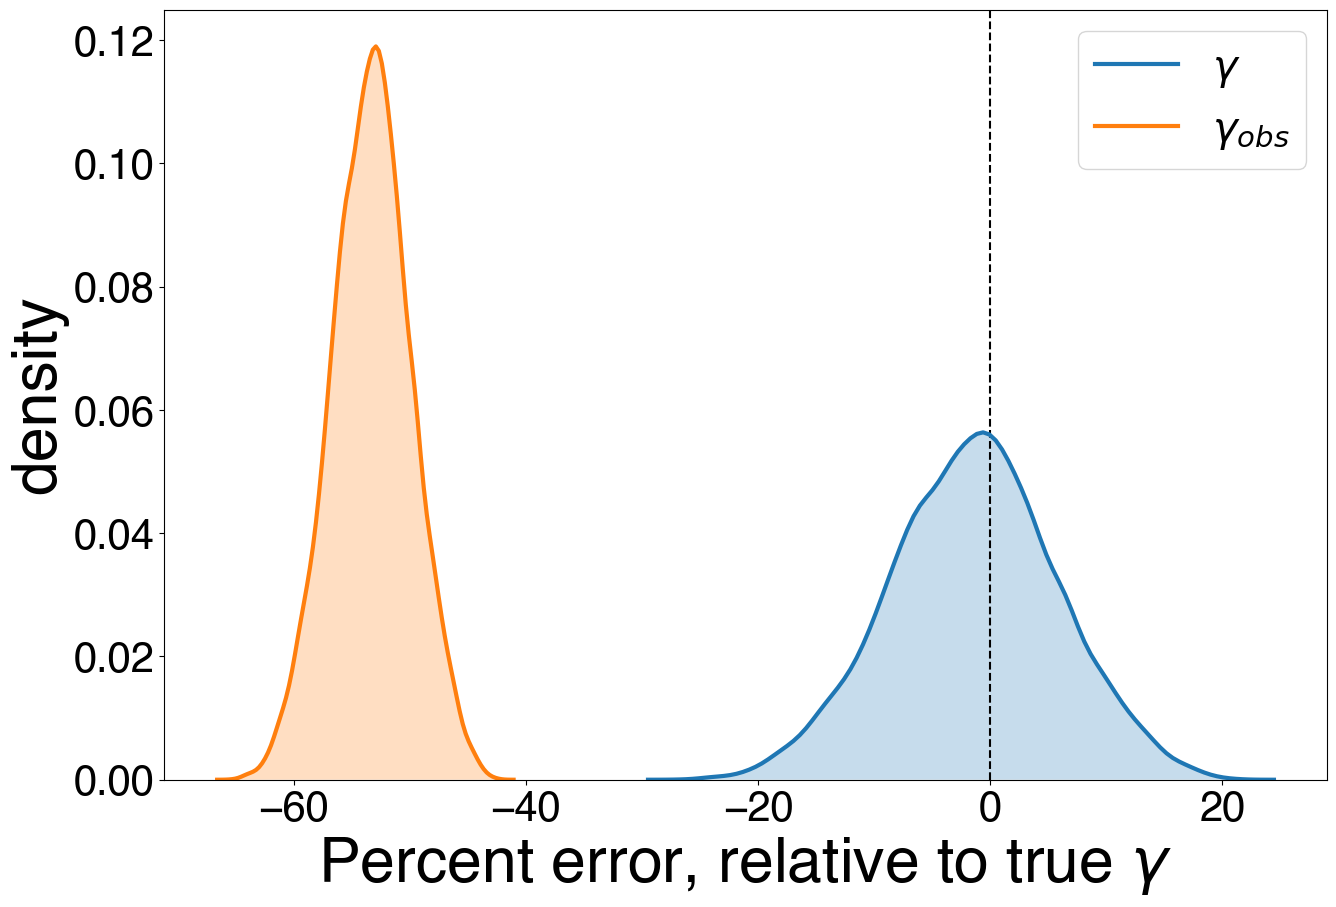

In [35]:
# plot the data
plotname_in = "L2_fast_g1_u1_cvg_200_gamma_PEs.svg";
make_plot((fast_g1_u1_200[0],fast_g1_u1_200[1]), plot_name = plotname_in, plot_type = 'density')

## 2 driver subclones

In [11]:
def roundup(x):
    ret = math.ceil(x/100)*100
    return(ret)
def violins_for_2_subclones(directory = None, csv_filename = None, true_filename = "true_params.txt", ymin = None,
                           ylim = None,  delta = 0, output_file = None):
    df = pd.read_csv(directory+csv_filename)
    true_df = pd.read_csv(directory+true_filename)

    delta_tf = 0
    counter = 0

    if csv_filename[:4]=='nest':
        delta = true_df['delta'][0]
        df = df.rename(columns = {"t_hat": "tpdelta_hat"})

        df['t_hat'] = (1/df['r2_hat'])*np.log(df['WBC1[2]'])
        true_df = true_df.drop('delta', axis = 1)
        delta_tf = 1
        #reorder columns
        true_df = true_df[['r','r1','r2','u','t1','t2','t']]
        x_ticks = ['$r$','$r_1$','$r_2$','$u$','$t_1$','$t_2$','$t$']
    if  csv_filename[:4]=='sibl':
        true_df = true_df.rename(columns = {"tau2": "t"})
        df = df.rename(columns = {"tau2_hat": "t_hat"})
        true_df = true_df[['r','r1','r2','u','t1','t2','t']]
        x_ticks = ['$r$','$r_1$','$r_2$','$u$','$t_1$','$t_2$','$t$']
    df_PE = np.zeros((df.shape[0],true_df.shape[1])) 
    
    for col in true_df.columns.values:
        df_col_name = col+'_hat'

        df_PE[:,counter] = 100*(df[df_col_name].values - true_df[col][0])/true_df[col][0]
        counter += 1
       
    pd_df_PE = pd.DataFrame(df_PE)
    locs = np.arange(len(true_df.columns.values))+1;    
    median_props = dict(linewidth=4, color = 'black')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5*20/7, 10))
    vp = ax.violinplot(df_PE, points=200, widths=0.7, showmeans=False,showextrema=False, showmedians=False, 
                       positions = locs)
    for bod in vp['bodies']:
        bod.set_facecolor('xkcd:azure')
        bod.set_alpha(.75)

    bp = ax.boxplot(df_PE,widths=.3,whis=[2.5,97.5],showfliers=False, positions = locs, medianprops = median_props)

    ax.set_xticklabels(true_df.columns.values,fontsize = 1.5)
    fs = 30;
    ax.tick_params(axis = "y",labelsize = fs)
    ax.set_xticklabels(true_df.columns.values,fontsize = 1.5*fs)
    ax.set_xticklabels(x_ticks,fontsize = 1.5*fs)
    if ylim == None:
        ylim_auto = roundup(max([item.get_ydata()[1] for item in bp['whiskers']]))
    else:
        ylim_auto = ylim
    if ymin == None:
        if min([item.get_ydata()[1] for item in bp['whiskers']]) < 0 and min([item.get_ydata()[1] for item in bp['whiskers']]) > -50:
            ymin = -50
        elif min([item.get_ydata()[1] for item in bp['whiskers']]) < -50 and min([item.get_ydata()[1] for item in bp['whiskers']]) > -100:
            ymin = -100
        else:
            ymin = -200
    ax.set_ylim(ymin, ylim_auto)
    mape_plotting_shift = (5/110)*(ylim_auto-ymin);
    mape_yloc = ylim_auto - mape_plotting_shift;
    mean_yloc = ylim_auto ;
    for j in locs:
        mape = np.mean(np.abs(df_PE),axis = 0)[j-1];
        #print("MAPE:")
        #print(mape)
        avg = np.mean(df_PE,axis = 0)[j-1];
        #print("MPE:")
        #print(avg)
        ax.annotate(str(round(avg,2))+'%',xy=(j-.15,mean_yloc),fontsize = fs,color = "black") #changed from 1*fs
        ax.annotate(str(round(mape,2))+'%',xy=(j-.15,mape_yloc),fontsize = fs,color = "slategrey")

    ax.yaxis.grid(True)
    plt.ylabel('% Error', fontsize = 1.5*fs)
    plt.tight_layout()

    if output_file != None:
        plt.savefig(output_file)
    plt.show()    

## Two sibling subclones, fast-growing, u = 1

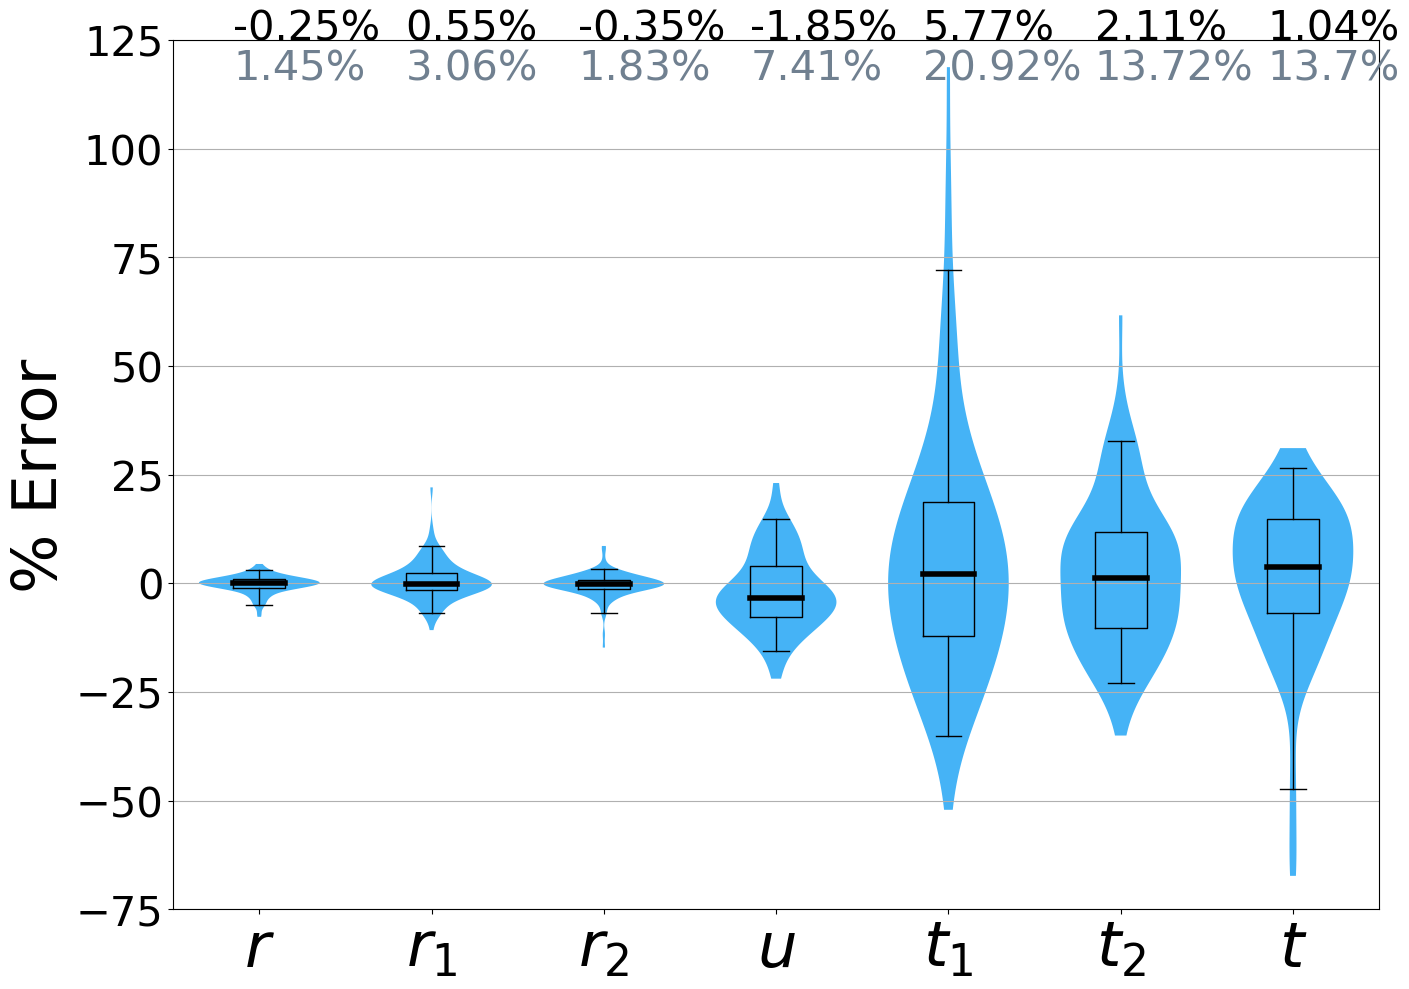

In [25]:
violins_for_2_subclones(directory = "data/2_siblings/fast/",
                        csv_filename="sibling_subclones_simulation_results.txt",ylim = 125, ymin = -75, output_file="sibling_fast.svg")

## Two sibling subclones, no cell death, u = 1

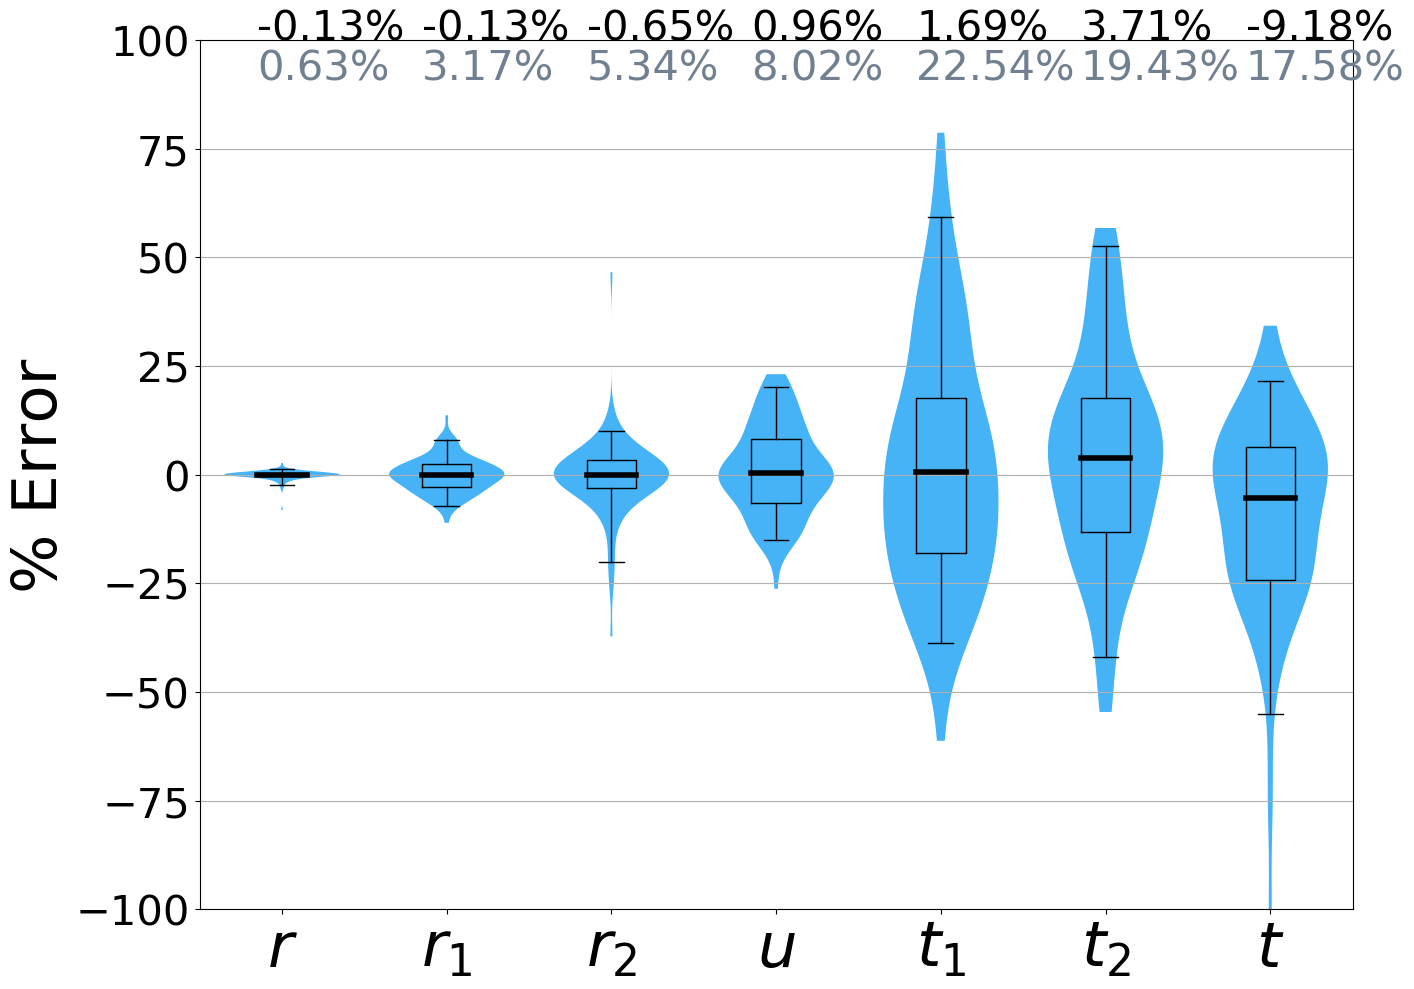

In [26]:
violins_for_2_subclones(directory = "data/2_siblings/no_death/",
                        csv_filename="sibling_subclones_simulation_results.txt",output_file="sibling_no_death.svg")

## two sibling, slow-growing, u = 1

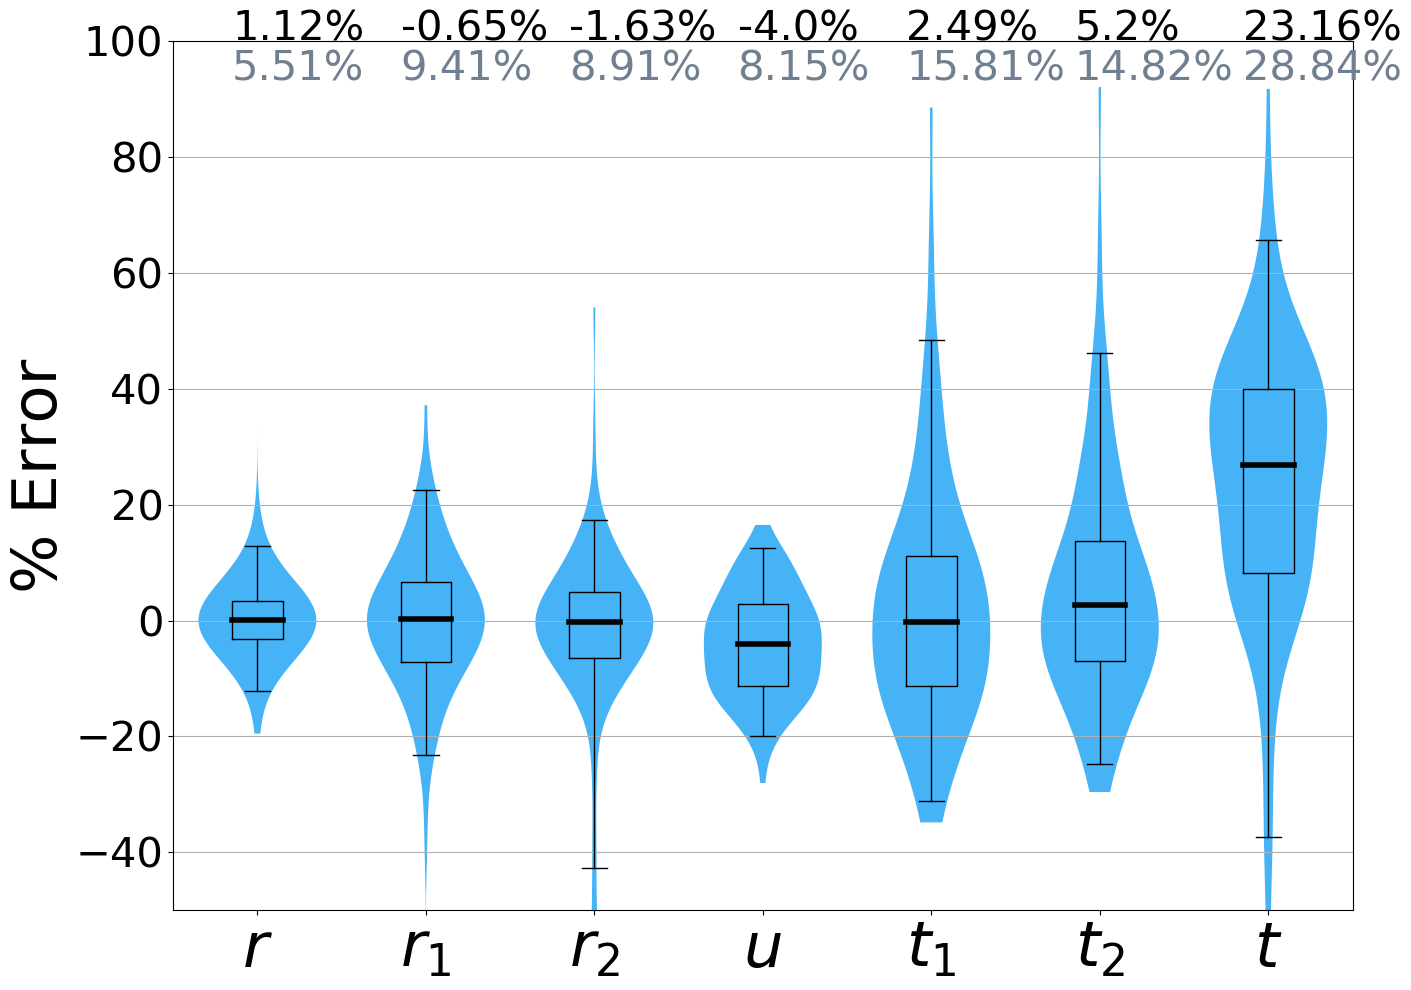

In [27]:
violins_for_2_subclones(directory = "data/2_siblings/slow/",
                        csv_filename="sibling_subclones_simulation_results.txt", output_file="sibling_slow.svg")

## 2 nested subclones, fast-growing, u = 1

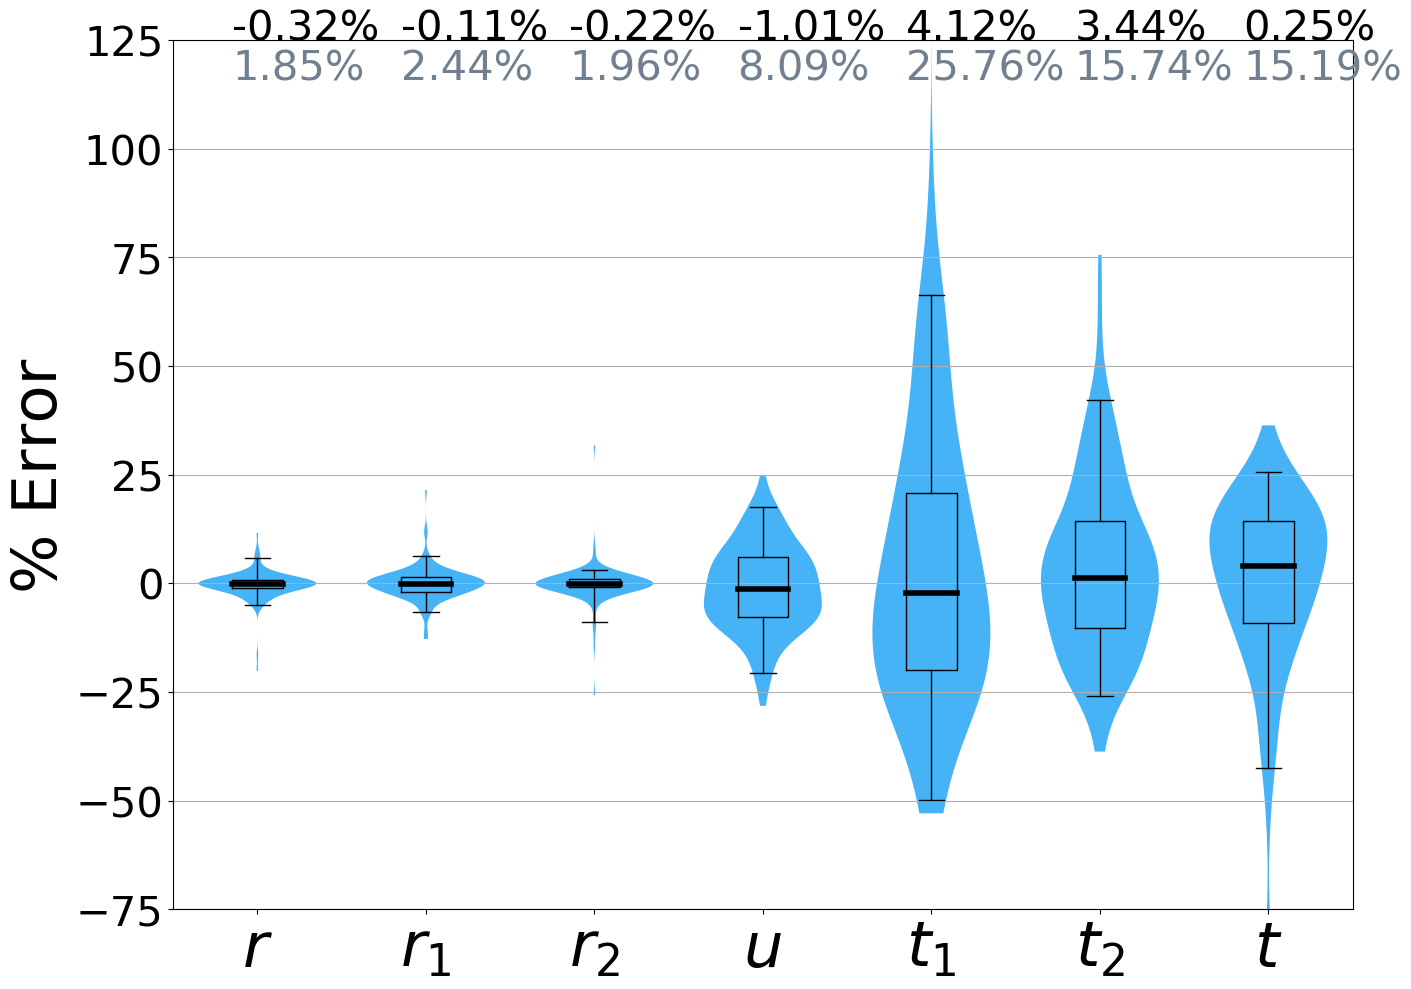

In [28]:
violins_for_2_subclones(directory = "data/2_nested/fast/",
                        csv_filename="nested_subclones_simulation_results.txt",ymin = -75, ylim = 125,output_file="nested_fast.svg")

## 2 nested subclones, slow-growing, u = 1

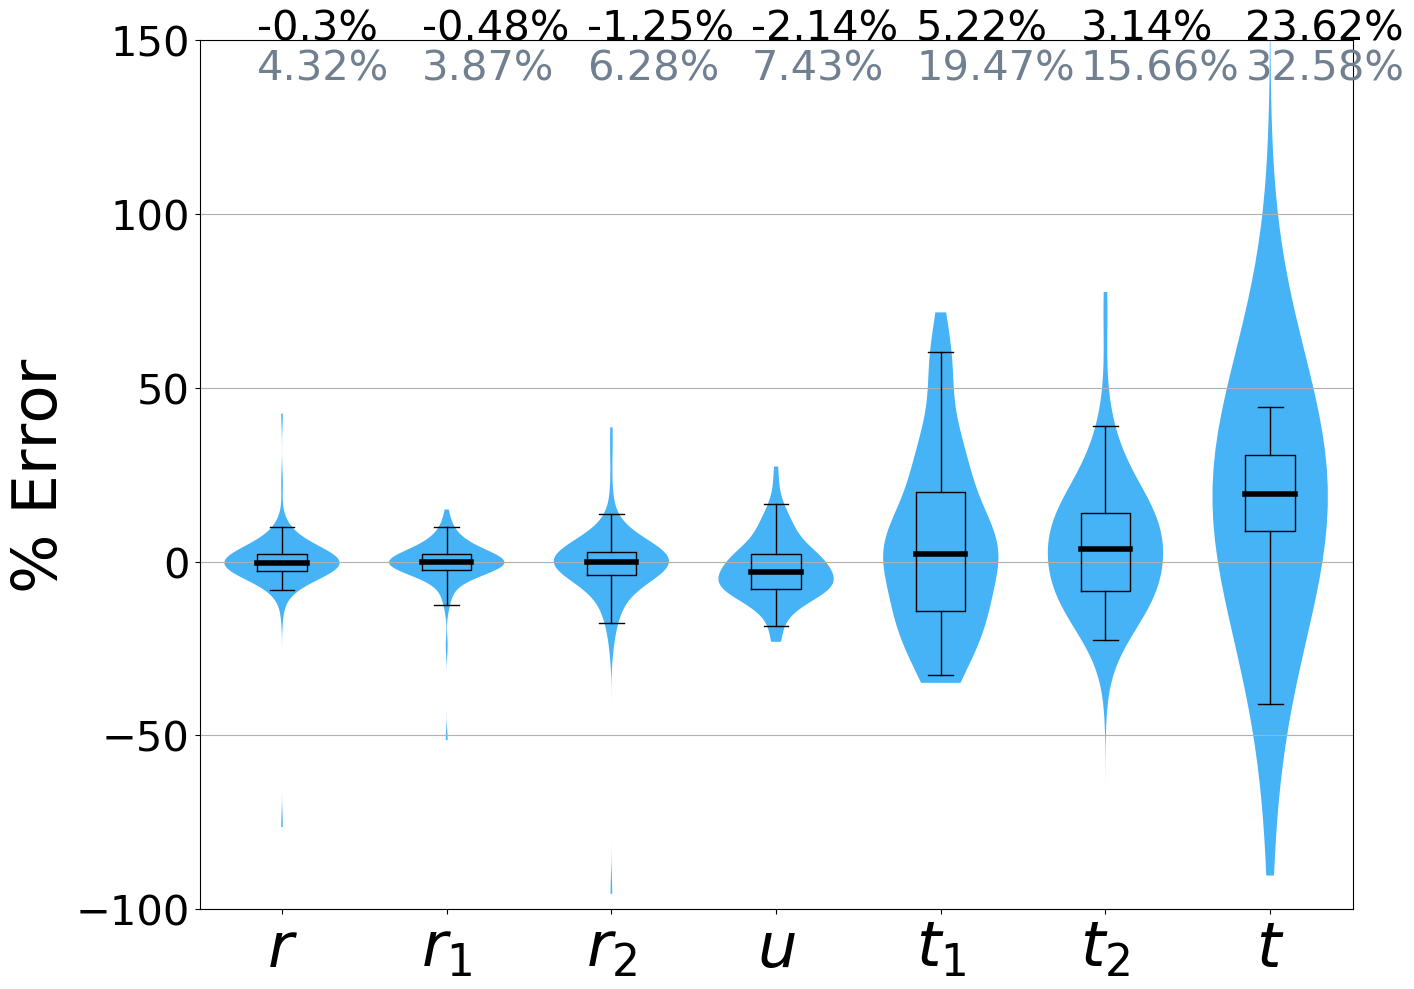

In [29]:
violins_for_2_subclones(directory = "data/2_nested/slow/",
                        csv_filename="nested_subclones_simulation_results.txt", ymin = -100, ylim = 150,output_file="nested_slow.svg")

## 2 nested subclones, no death, u = 1

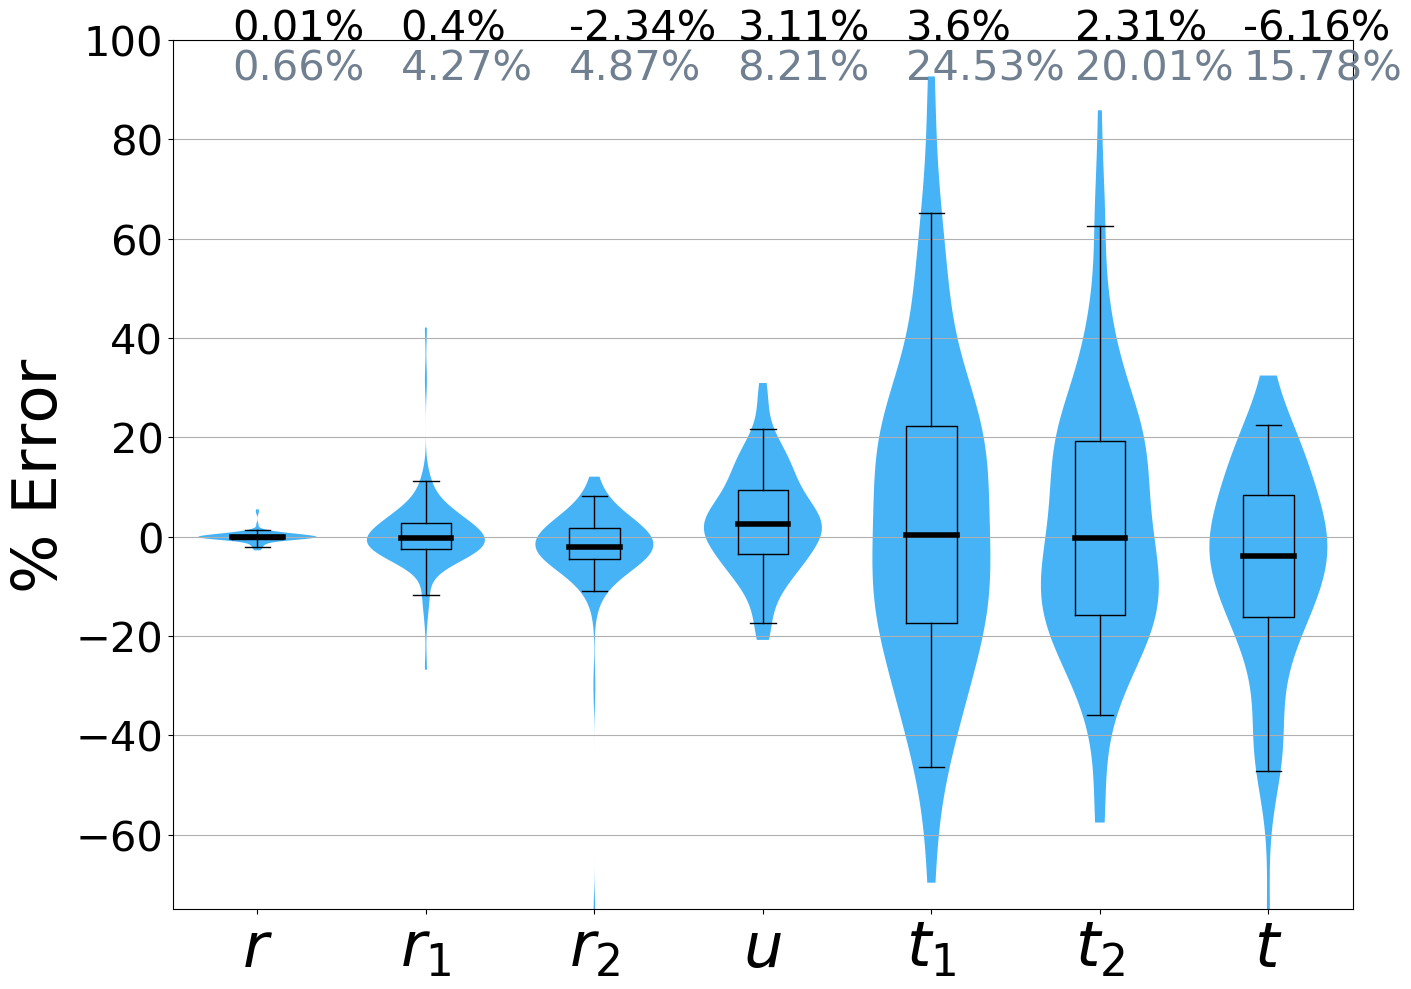

In [30]:
violins_for_2_subclones(directory = "data/2_nested/no_death/",
                        csv_filename="nested_subclones_simulation_results.txt", ylim = 100, ymin = -75, output_file="nested_no_death.svg")